# Kmeans motifs

## Kmeans

### Data

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from katlas.core import *
from katlas.plot import *
import pandas as pd, numpy as np

In [ ]:
human = pd.read_parquet('raw/human_phosphoproteome.parquet')
df_grouped = pd.read_parquet('raw/combine_source_grouped.parquet')

In [ ]:
all_site = pd.concat([human,df_grouped])

In [ ]:
all_site.sub_site.isna().sum()

np.int64(0)

In [ ]:
all_site = all_site.drop_duplicates('sub_site')

In [ ]:
# all_site = all_site[['sub_site','site_seq']].drop_duplicates('sub_site')

### Elbow method

In [ ]:
def determine_clusters_elbow(encoded_data,interval=50):

    wcss = []
    for i in range(1, 400,interval):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(encoded_data)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow graph
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, 400,interval), wcss)
    plt.title(f'Elbow Method (n={len(encoded_data)})')
    plt.xlabel('# Clusters')
    plt.ylabel('WCSS')

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

In [ ]:
%%time
onehot = onehot_encode(all_site['site_seq'])

CPU times: total: 3.39 s
Wall time: 3.44 s


In [ ]:
all_site.shape

(131843, 13)

In [ ]:
# %%time
# determine_clusters_elbow(onehot)

### Kmeans

If using RAPIDS

In [ ]:
# # pip install --extra-index-url=https://pypi.nvidia.com \"cudf-cu12==25.2.*\" \"cuml-cu12==25.2.*\"

# %load_ext cudf.pandas

# import numpy as np, pandas as pd
# from cuml import KMeans
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# from katlas.core import *
# from katlas.plot import *

In [ ]:
def kmeans(onehot,n=2,seed=42):
    kmeans = KMeans(n_clusters=n, random_state=seed,n_init='auto')
    return kmeans.fit_predict(onehot)

In [ ]:
ncluster=[50,150,300]
seeds=[42,2025,28]

In [ ]:
pssms=[]
for seed in seeds:
    print('seed',seed)
    for n in ncluster:
        colname = f'cluster{n}_seed{seed}'
        print(colname)
        onehot = onehot_encode(all_site['site_seq'])
        all_site[colname] = kmeans(onehot,n=n,seed=seed)
        pssm_df = extract_motifs(all_site,colname,valid_thr=0.5)
        pssm_df.index =colname+'_'+pssm_df.index.astype(str)
        pssms.append(pssm_df)

In [ ]:
pssms = pd.concat(pssms,axis=0)
# pssms.to_parquet('raw/kmeans.parquet')

In [ ]:
# all_site.to_parquet('raw/kmeans_site.parquet',index=False)

In [ ]:
pssms = pd.read_parquet('raw/kmeans.parquet')

In [ ]:
all_site=pd.read_parquet('raw/kmeans_site.parquet')

In [ ]:
all_site.head()

sub_site                                   site_seq  \
0  A0A024R4G9_S20  _MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR   
1  A0A075B6Q4_S24  QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG   
2  A0A075B6Q4_S35  EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF   
3  A0A075B6Q4_S57  EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN   
4  A0A075B6Q4_S68  RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE   

   cluster50_seed42  cluster150_seed42  cluster300_seed42  cluster50_seed2025  \
0                33                 97                249                  41   
1                37                 97                  9                  42   
2                45                102                  2                  30   
3                30                100                201                  30   
4                11                 75                 68                  10   

   cluster150_seed2025  cluster300_seed2025  cluster50_seed28  \
0                   53                   53                 3   
1                  117                   28                 2   
2                  122                  122                 6   
3                   58                   58                18   
4                   48                  164                39   

   cluster150_seed28  cluster300_seed28  
0                 45                261  
1                149                137  
2                149                149  
3                 35                252  
4                 96                226

Expand the cluster into a single column

In [ ]:
id_vars = ['sub_site', 'site_seq']
value_vars = [col for col in all_site.columns if col.startswith('cluster')]

In [ ]:
all_site_long = pd.melt(all_site, id_vars=id_vars, value_vars=value_vars, var_name='cluster_info', value_name='cluster')

In [ ]:
all_site_long['cluster_id']=all_site_long['cluster_info'] + '_' + all_site_long['cluster'].astype(str)

In [ ]:
all_site_long.head()

sub_site                                   site_seq  \
0  A0A024R4G9_S20  _MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR   
1  A0A075B6Q4_S24  QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG   
2  A0A075B6Q4_S35  EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF   
3  A0A075B6Q4_S57  EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN   
4  A0A075B6Q4_S68  RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE   

       cluster_info  cluster           cluster_id  
0  cluster50_seed42       33  cluster50_seed42_33  
1  cluster50_seed42       37  cluster50_seed42_37  
2  cluster50_seed42       45  cluster50_seed42_45  
3  cluster50_seed42       30  cluster50_seed42_30  
4  cluster50_seed42       11  cluster50_seed42_11

In [ ]:
# all_site_long.to_parquet('raw/kmeans_site_long.parquet',index=False)

### Get JS distance

Get 1D distance

In [ ]:
def compute_distance_matrix(df,func=js_divergence_flat):

    n = len(df)
    dist = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            d = func(df.iloc[i].values, df.iloc[j].values)
            dist.append(d)
    return np.array(dist)

In [ ]:
distances = compute_distance_matrix(pssms)

100%|██████████| 1460/1460 [01:56<00:00, 12.50it/s] 


In [ ]:
distances

array([0.02902039, 0.02301795, 0.0316568 , ..., 0.20584111, 0.32253787,
       0.28244867])

### Hierarchical clustering

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

In [ ]:
Z = linkage(distances, method='ward')

In [ ]:
def plot_dendrogram(Z,output='raw/dendrogram.pdf',color_thr=0.03,**kwargs):
    length=(len(Z)+1)//8
    
    plt.figure(figsize=(5,length))
    dendrogram(Z, orientation='left', leaf_font_size=7, color_threshold=color_thr,**kwargs)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('Distance')
    plt.savefig(output, bbox_inches='tight')
    plt.close()

In [ ]:
labels = [i+': '+pssm_to_seq(recover_pssm(r),0.2) for i,r in pssms.iterrows()]

In [ ]:
labels[:5]

['cluster50_seed42_17: ....................t*....................',
 'cluster50_seed42_10: ....................t*s[s/P]..................',
 'cluster50_seed42_31: ....................y*....................',
 'cluster50_seed42_2: ....................y*....................',
 'cluster50_seed42_7: ....................s*....................']

In [ ]:
plot_dendrogram(Z,output='raw/dendrogram_label.pdf',labels=labels)

In [ ]:
plot_dendrogram(Z) # with only index number

In [ ]:
def plot_motifs(pssm_df,*idxs):

    for idx in idxs:
        pssm = recover_pssm(pssm_df.loc[idx])
        plot_logo(pssm,figsize=(14,1))
        plt.show()
        plt.close()

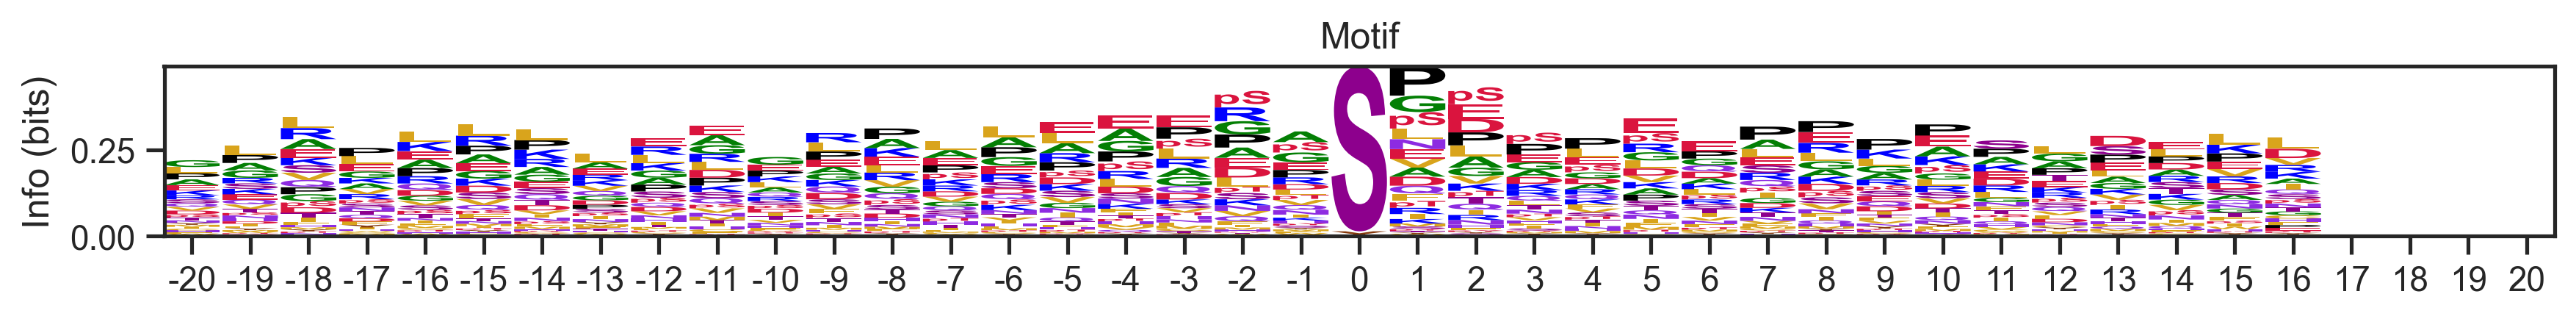

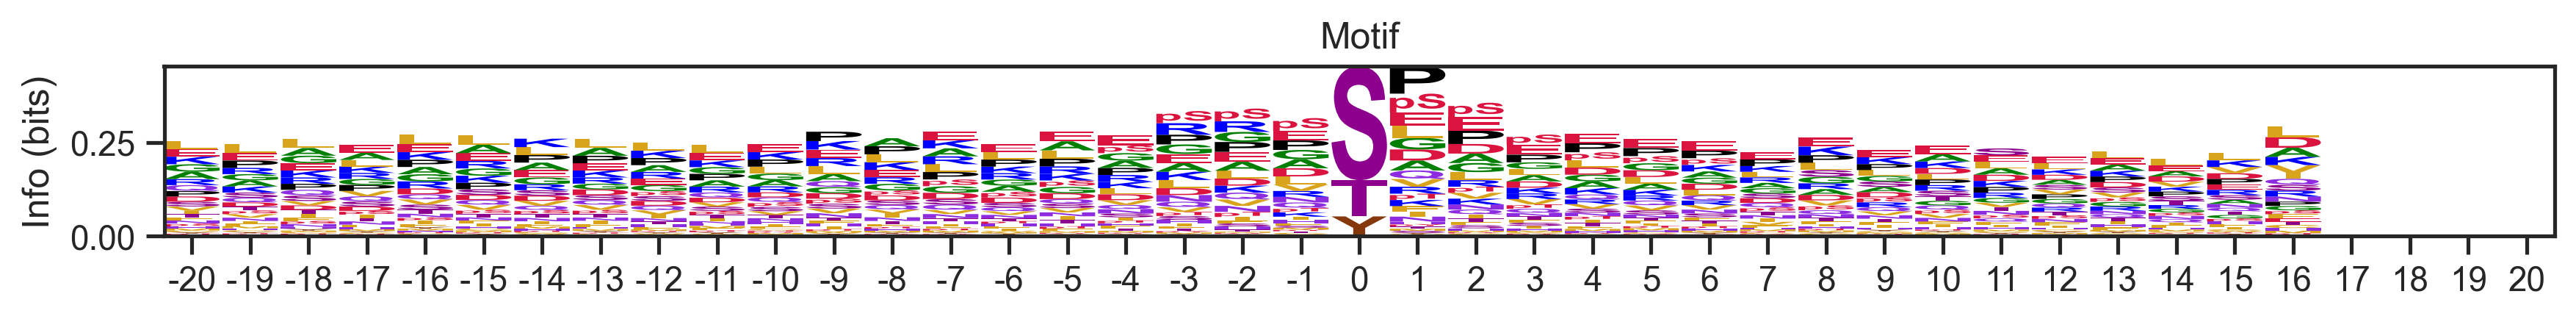

In [ ]:
plot_motifs(pssms, 'cluster300_seed28_217','cluster50_seed42_40')

### Cut trees

In [ ]:
labels = fcluster(Z, t=0.03, criterion='distance')
# pssm_df['cluster'] = labels

In [ ]:
Z.shape

(1459, 4)

### Map new cluster

In [ ]:
cluster_map = pd.Series(labels,index=pssms.index)

In [ ]:
pssms.index # note that pssms does not contain all cluster, as it already filter out low quality pssm

Index(['cluster50_seed42_17', 'cluster50_seed42_10', 'cluster50_seed42_31',
       'cluster50_seed42_2', 'cluster50_seed42_7', 'cluster50_seed42_29',
       'cluster50_seed42_39', 'cluster50_seed42_16', 'cluster50_seed42_33',
       'cluster50_seed42_48',
       ...
       'cluster300_seed28_26', 'cluster300_seed28_186', 'cluster300_seed28_5',
       'cluster300_seed28_70', 'cluster300_seed28_266', 'cluster300_seed28_30',
       'cluster300_seed28_277', 'cluster300_seed28_110',
       'cluster300_seed28_221', 'cluster300_seed28_174'],
      dtype='object', length=1460)

In [ ]:
all_site_long['cluster_new'] = all_site_long.cluster_id.map(lambda x: cluster_map.get(x, 0)) #0 is unmapped

In [ ]:
# all_site_long.to_parquet('raw/kmeans_site_long_new_cluster.parquet',index=False)

### Get new cluster motifs

In [ ]:
def extract_motifs2(df, cluster_col, seq_col='site_seq', count_thr=10, valid_thr=None,plot=False):
    "Extract motifs from clusters in a dataframe"
    pssms = []
    ids = []
    value_counts = df[cluster_col].value_counts()
    for cluster_id, counts in tqdm(value_counts.items(),total=len(value_counts)):
        if count_thr is not None and counts <= count_thr:
            continue

        # Modify this line 
        # df_cluster = df[df[cluster_col] == cluster_id]
        df_cluster = df[df[cluster_col] == cluster_id].drop_duplicates('sub_site')
        n= len(df_cluster)
        pssm = get_prob(df_cluster, seq_col)
        valid_score = (pssm != 0).sum().sum() / (pssm.shape[0] * pssm.shape[1])

        if valid_thr is not None and valid_score <= valid_thr:
            continue

        pssms.append(flatten_pssm(pssm))
        ids.append(cluster_id)

        if plot:
            plot_logo(pssm, title=f'Cluster {cluster_id} (n={n})', figsize=(14, 1))
            plt.show()
            plt.close()

    pssm_df = pd.DataFrame(pssms, index=ids)
    return pssm_df

In [ ]:
all_site_long

sub_site                                   site_seq  \
0        A0A024R4G9_S20  _MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR   
1        A0A075B6Q4_S24  QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG   
2        A0A075B6Q4_S35  EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF   
3        A0A075B6Q4_S57  EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN   
4        A0A075B6Q4_S68  RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE   
...                 ...                                        ...   
1186582     Q9Y6I9_T257  EtsAAtLsPGASsRGWDDGDtRsEHSYsESGAsGssFEELD   
1186583     Q9Y6M4_S372  HRDKMQQSKNQSADHRAAWDsQQANPHHLRAHLAADRHGGS   
1186584     Q9Y6M4_T332  FDRKGYMFDyEyDWIGKQLPtPVGAVQQDPALssNREAHQH   
1186585    Q9Y6R4_T1324  FEEKRYREMRRKNIIGQVCDtPKSyDNVMHVGLRKVTFKWQ   
1186586    Q9Y6R4_Y1328  RYREMRRKNIIGQVCDtPKSyDNVMHVGLRKVTFKWQRGNK   

              cluster_info  cluster             cluster_id  cluster_new  
0         cluster50_seed42       33    cluster50_seed42_33          464  
1         cluster50_seed42       37    cluster50_seed42_37          448  
2         cluster50_seed42       45    cluster50_seed42_45          328  
3         cluster50_seed42       30    cluster50_seed42_30          536  
4         cluster50_seed42       11    cluster50_seed42_11          368  
...                    ...      ...                    ...          ...  
1186582  cluster300_seed28      170  cluster300_seed28_170          657  
1186583  cluster300_seed28      198  cluster300_seed28_198          430  
1186584  cluster300_seed28      146  cluster300_seed28_146          679  
1186585  cluster300_seed28      146  cluster300_seed28_146          679  
1186586  cluster300_seed28       86   cluster300_seed28_86          676  

[1186587 rows x 6 columns]

In [ ]:
all_site_long.cluster_new.sort_values().unique()[-10:]

array([737, 738, 739, 740, 741, 742, 743, 744, 745, 746])

746 motifs

  0%|          | 0/747 [00:00<?, ?it/s]

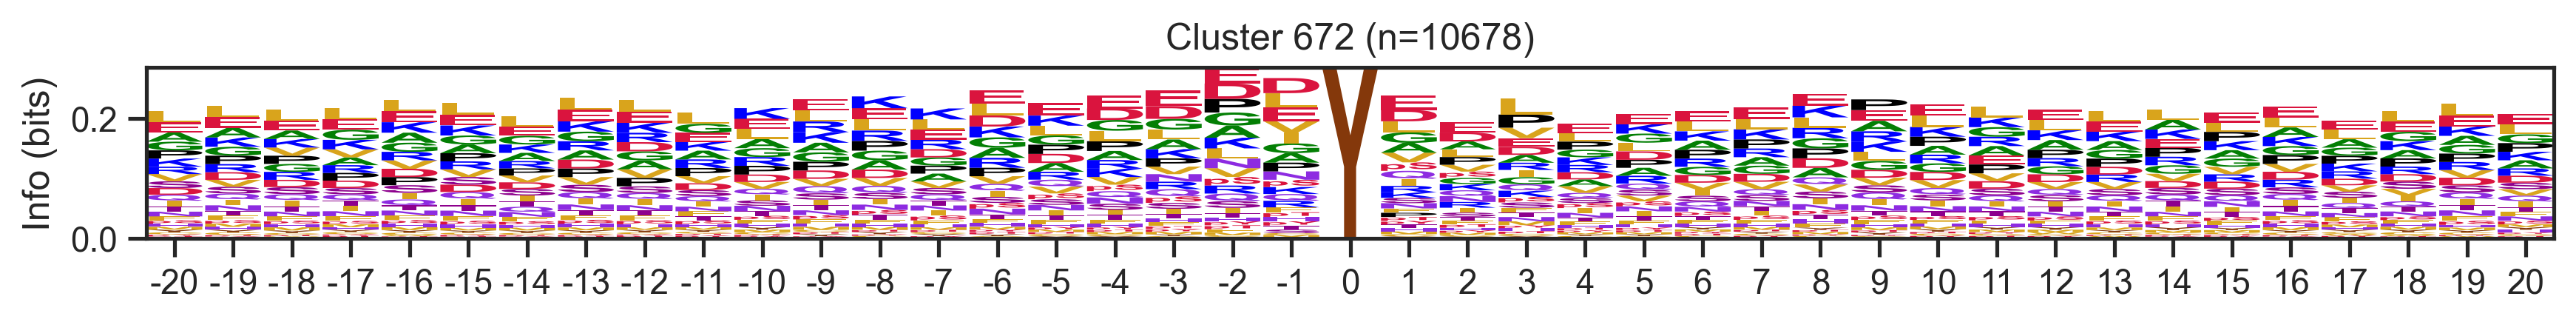

  0%|          | 1/747 [00:05<1:09:26,  5.59s/it]

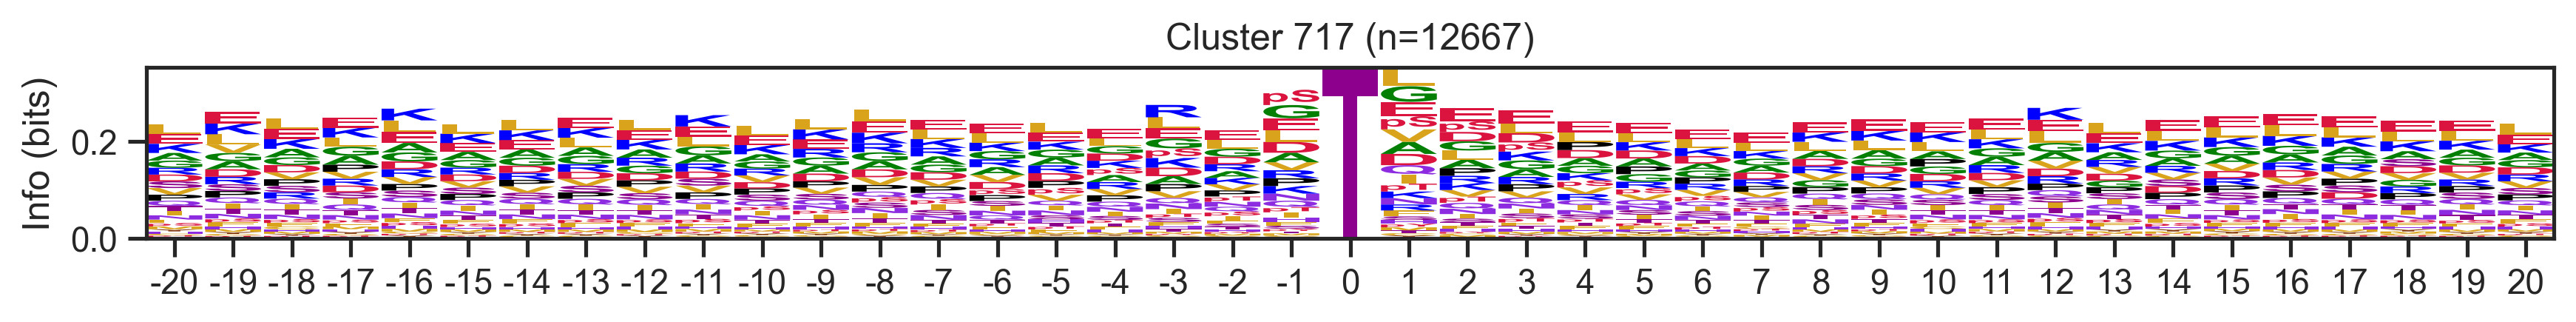

  0%|          | 2/747 [00:11<1:11:14,  5.74s/it]

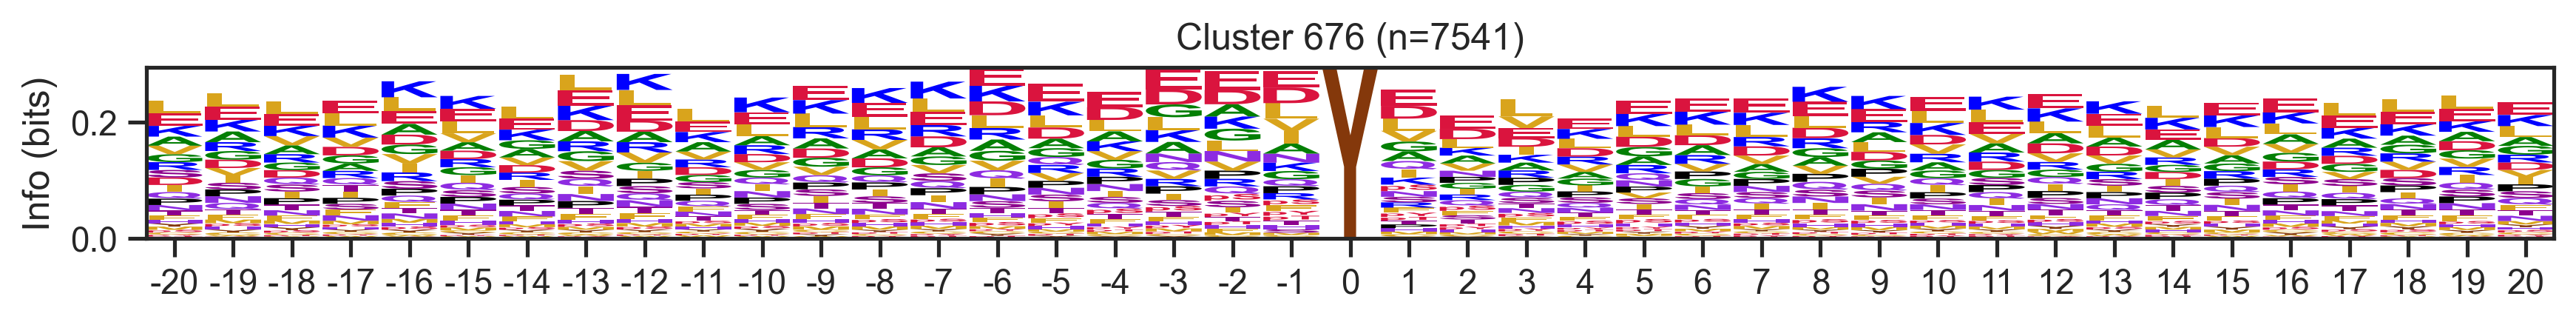

  0%|          | 3/747 [00:16<1:10:05,  5.65s/it]

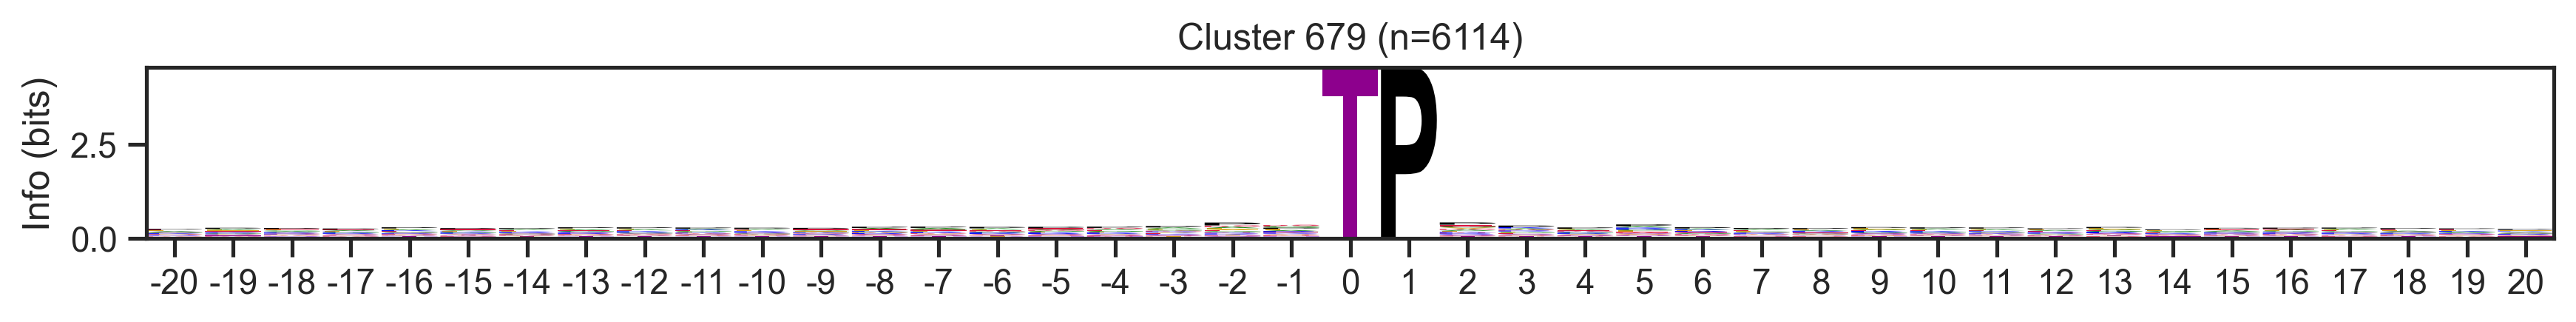

  1%|          | 4/747 [00:22<1:08:30,  5.53s/it]

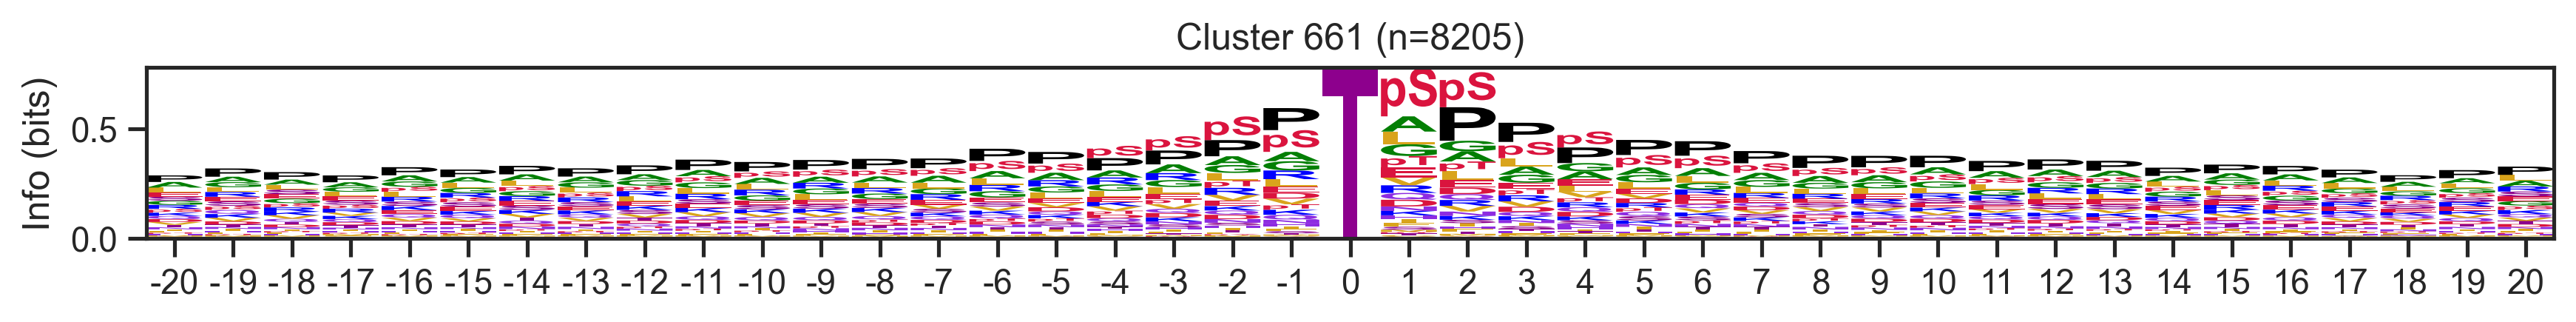

  1%|          | 5/747 [00:30<1:16:36,  6.19s/it]


KeyboardInterrupt: 

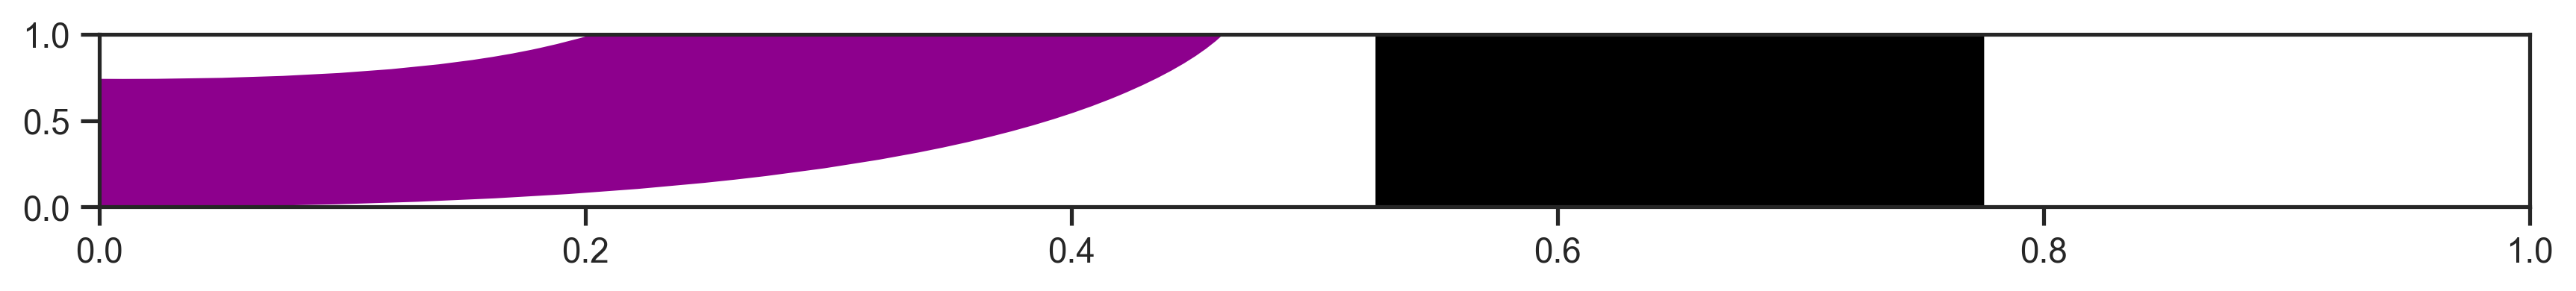

In [ ]:
_ = extract_motifs2(all_site_long,'cluster_new','site_seq',count_thr=10,valid_thr=0.3,plot=True)

In [ ]:
pssms2 = extract_motifs2(all_site_long,'cluster_new','site_seq',count_thr=10,valid_thr=0.3)

  0%|          | 0/747 [00:00<?, ?it/s]

100%|██████████| 747/747 [00:27<00:00, 26.95it/s]


In [ ]:
pssms3 = pssms2.copy()

In [ ]:
pssms2 = pssms2.drop(index=0) # as 0 represents unmapped

In [ ]:
distances = compute_distance_matrix(pssms2)
Z = linkage(distances, method='ward')


100%|██████████| 746/746 [00:29<00:00, 25.16it/s] 


In [ ]:
labels=[str(i)+': '+pssm_to_seq(recover_pssm(r),0.2) for i,r in pssms2.iterrows()]

In [ ]:
plot_dendrogram(Z,output='raw/dendrogram_label2.pdf',labels=labels,color_thr=0.07)

### Special sites - specific cluster

In [ ]:
n = all_site_long[all_site_long.cluster_new==725].sub_site.unique().shape[0]
print(n)
# all_site_long[all_site_long.cluster_new==725].sub_site.str.split('_').str[0].drop_duplicates().to_csv('any.csv')

174


Mostly Zinc finger protein

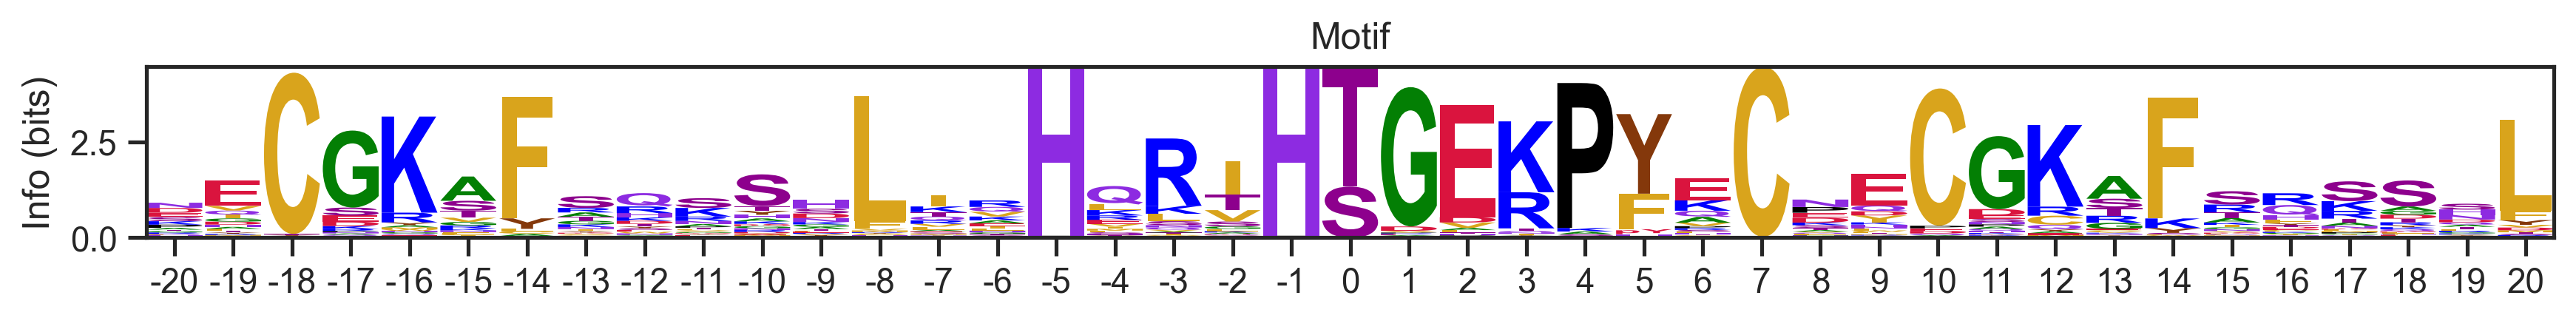

In [ ]:
plot_motifs(pssms2,725)

### Special sites - most common cluster

In [ ]:
all_site_pivot = all_site_long.pivot_table(
    index='sub_site',
    columns='cluster_new',
    aggfunc='size',
    fill_value=0
).map(lambda x: 1 if x > 0 else 0)

In [ ]:
all_site_pivot = all_site_pivot.drop(columns=0)

In [ ]:
# number of clusters that sites belong to
all_site_pivot.sum(1).sort_values().value_counts()

6    23049
5    22529
4    20836
7    19808
3    17321
8    11898
2    10719
9     3277
1     2406
Name: count, dtype: int64

In [ ]:
all_site_pivot.sum().sort_values(ascending=False)

cluster_new
717    12667
631    11035
672    10678
661     8205
70      7771
       ...  
516      119
12       115
171      110
387      106
20        66
Length: 746, dtype: int64

In [ ]:
idxs = all_site_pivot.sum().sort_values(ascending=False).index[:20]

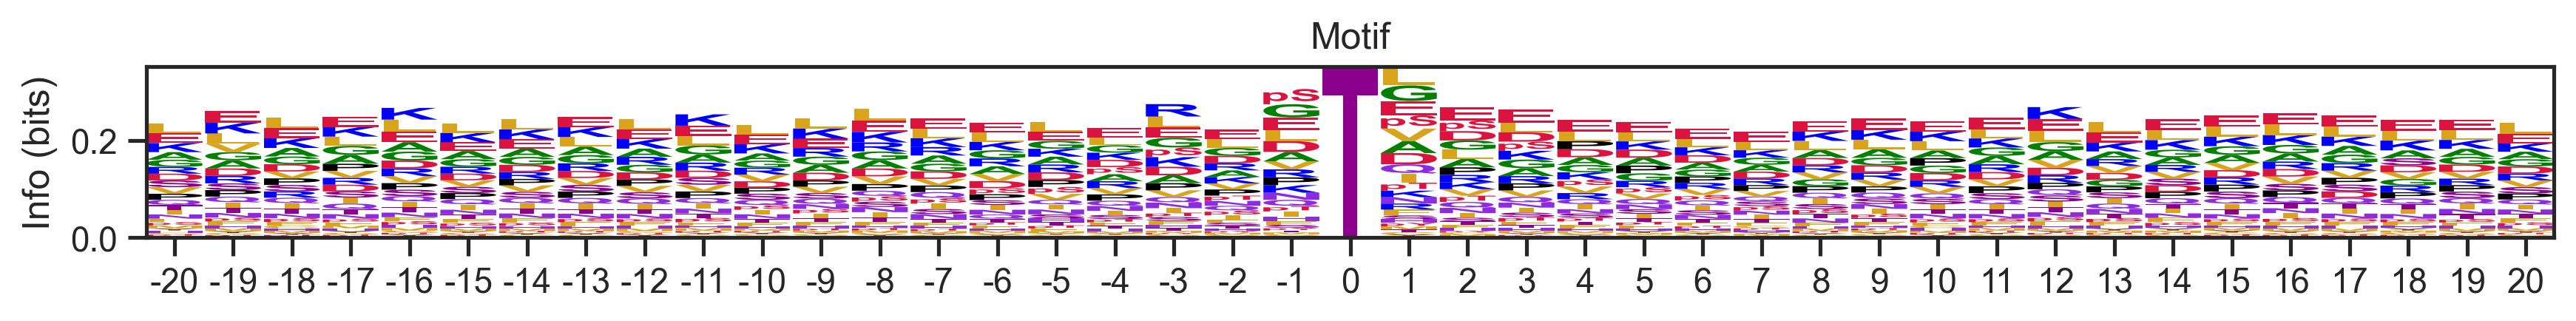

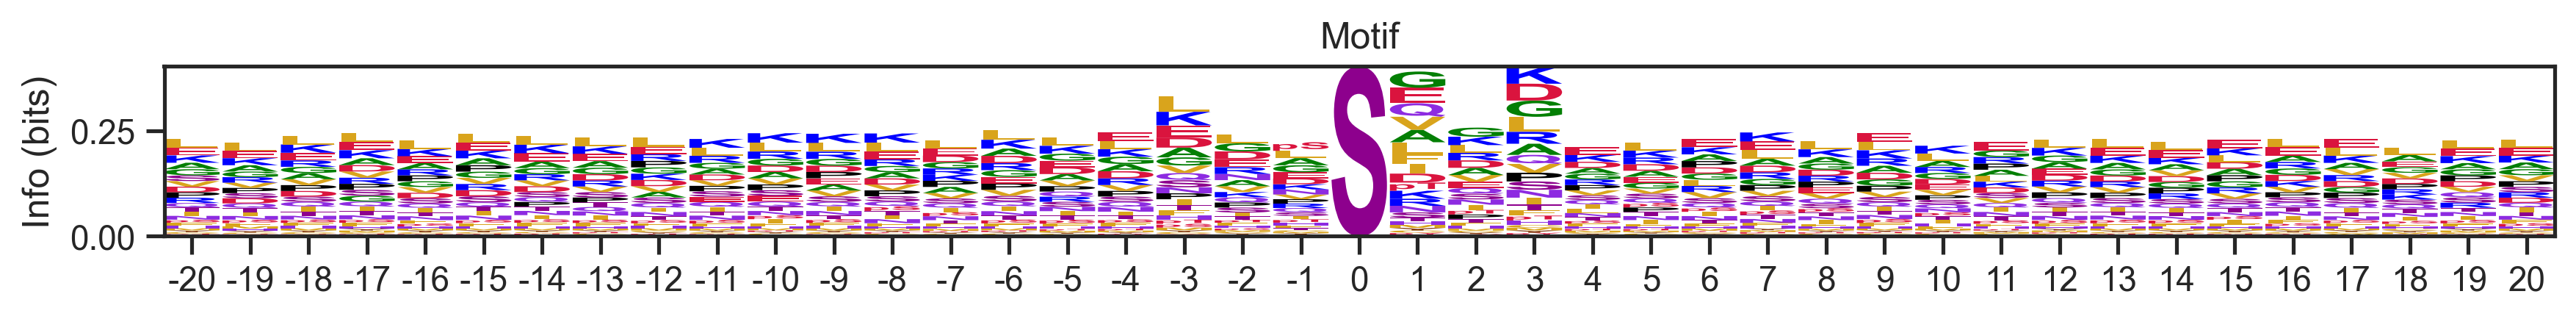

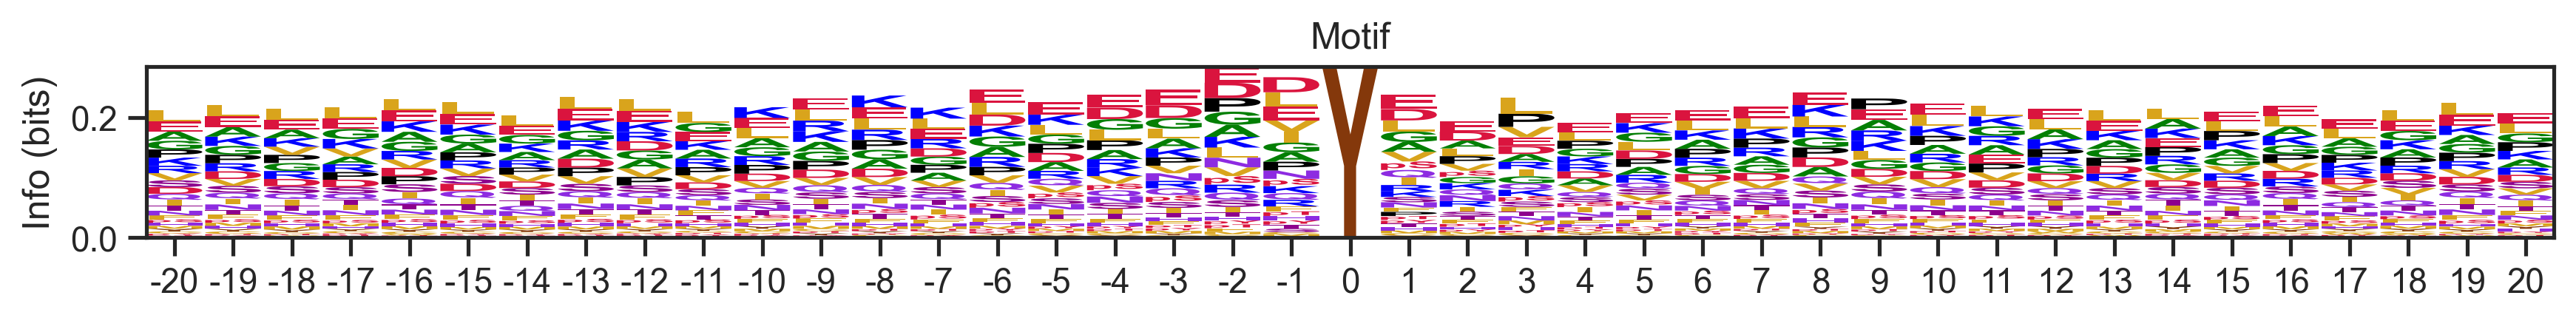

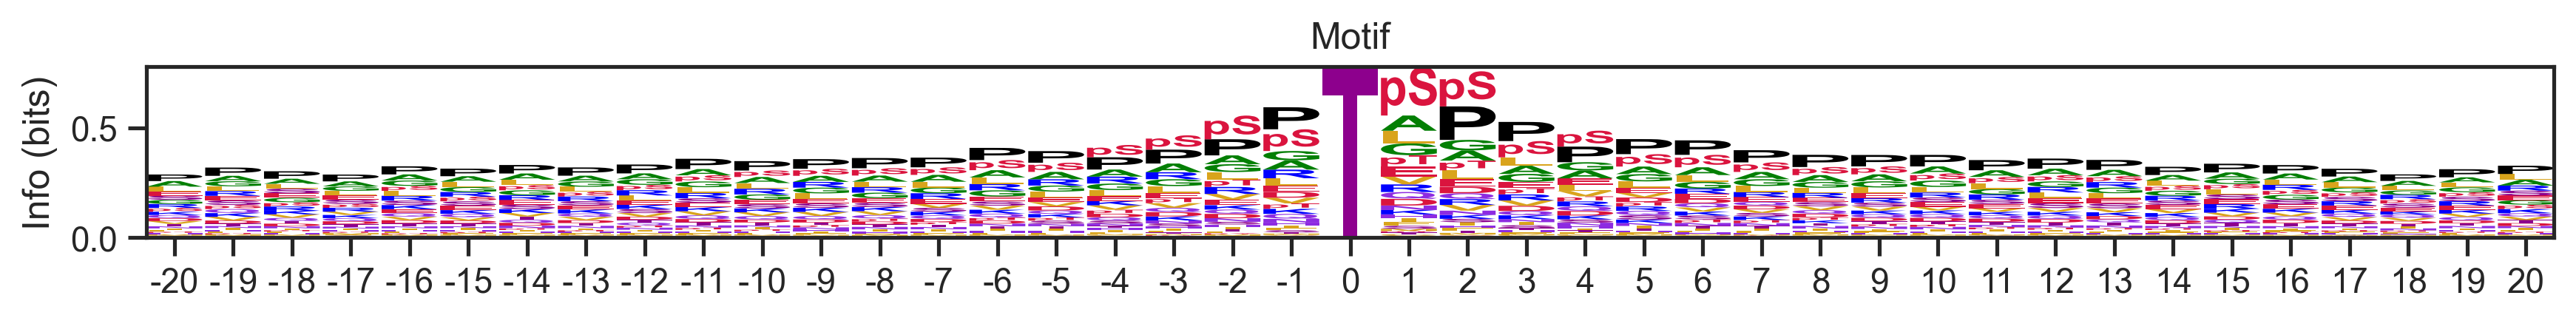

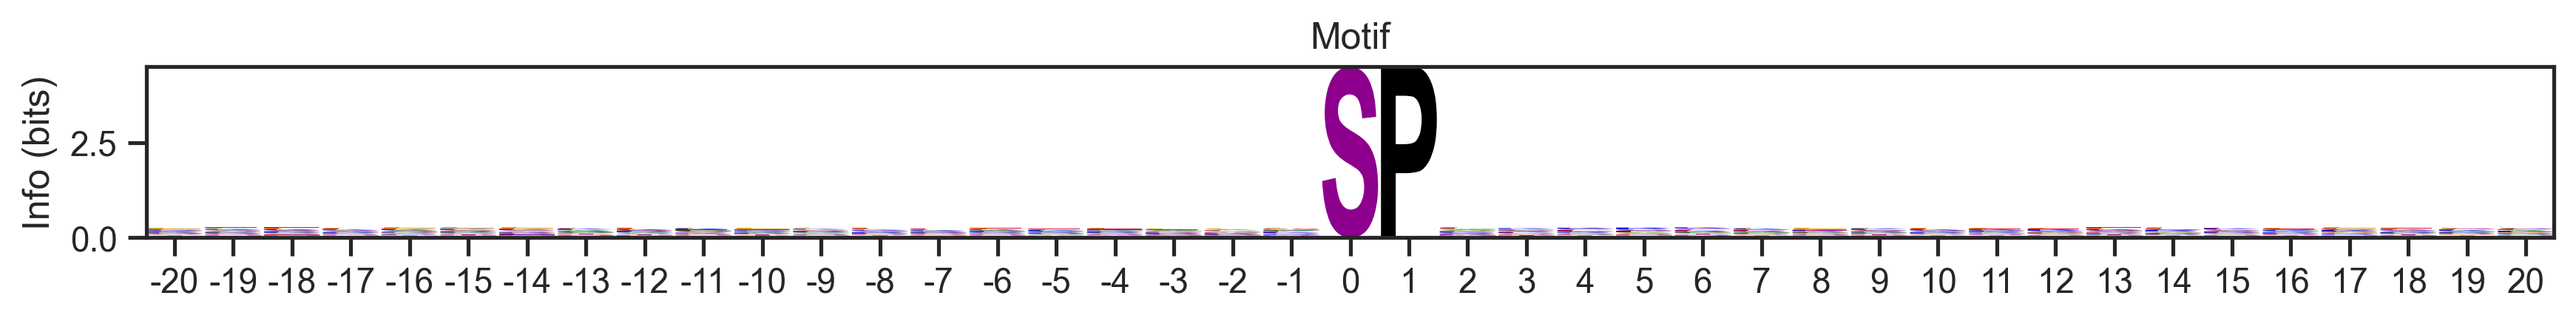

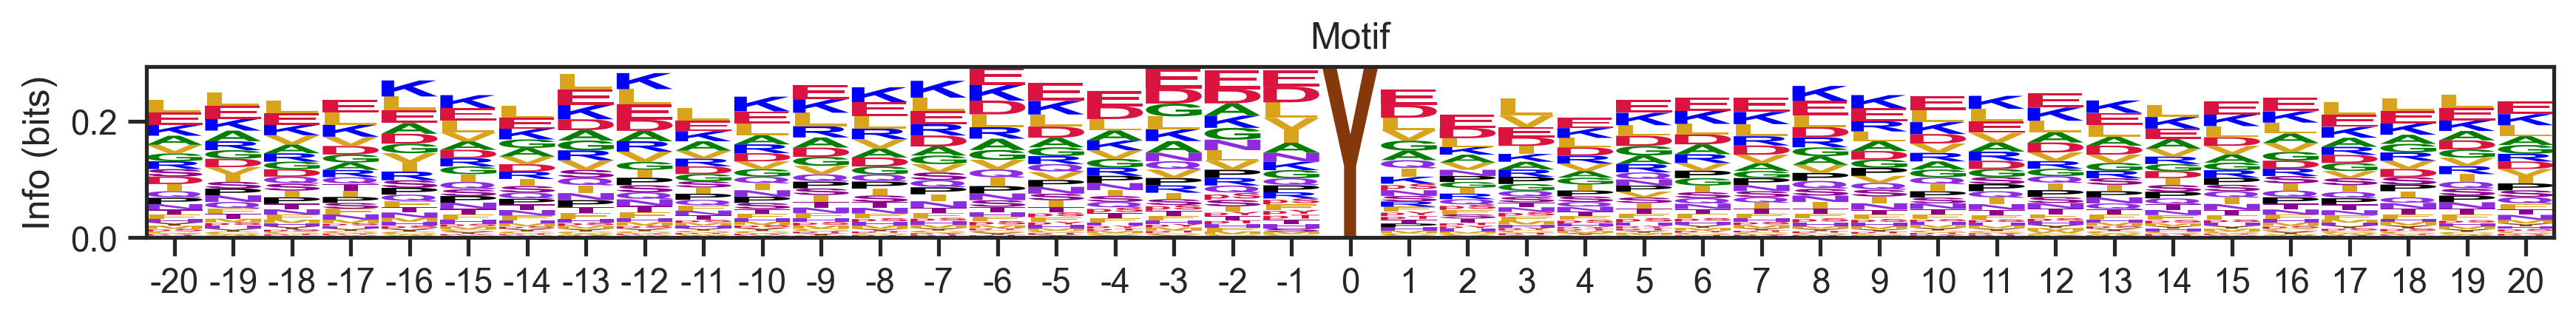

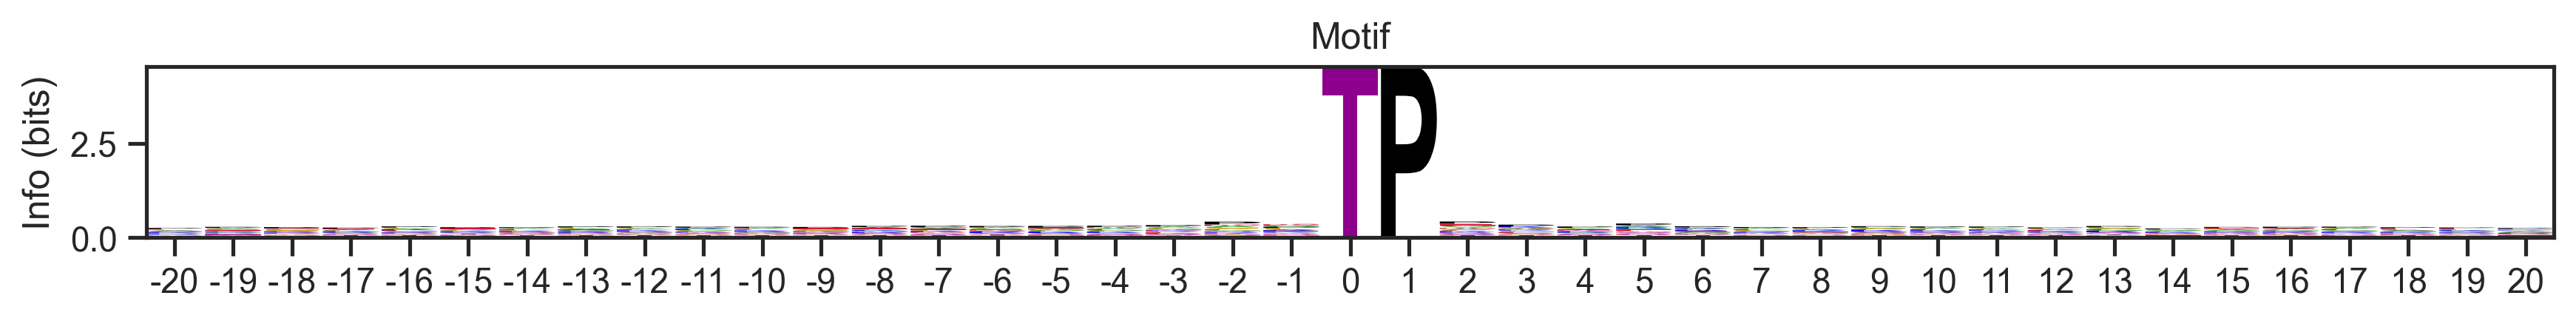

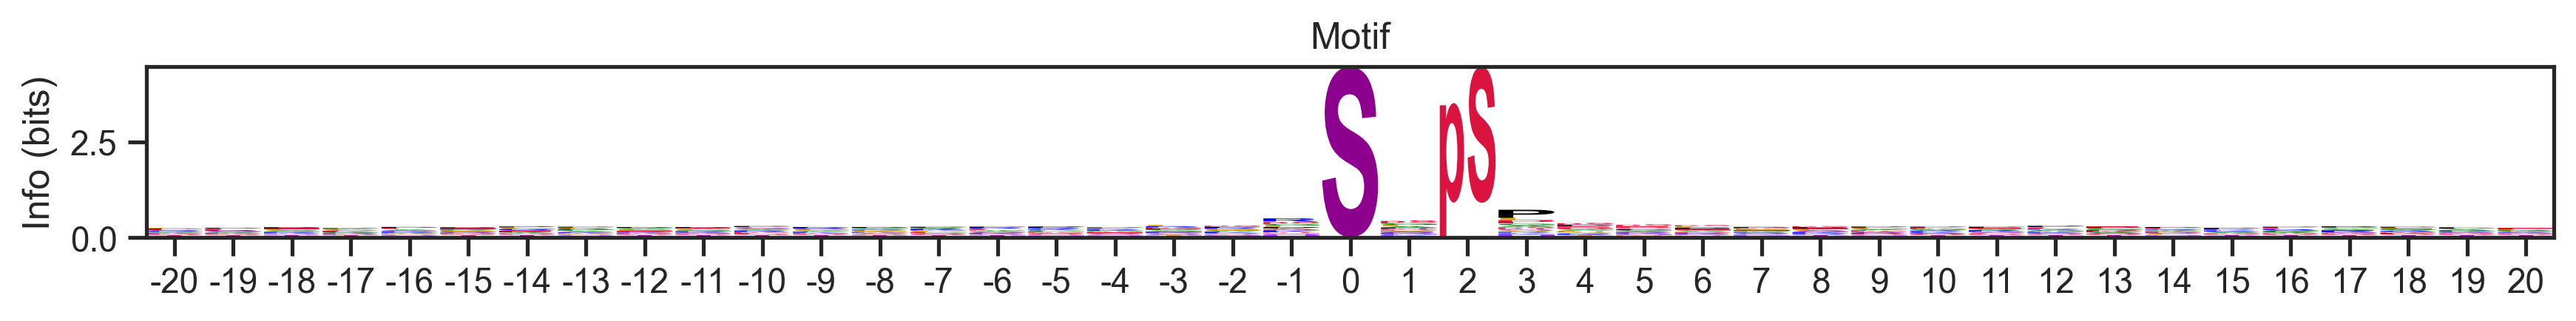

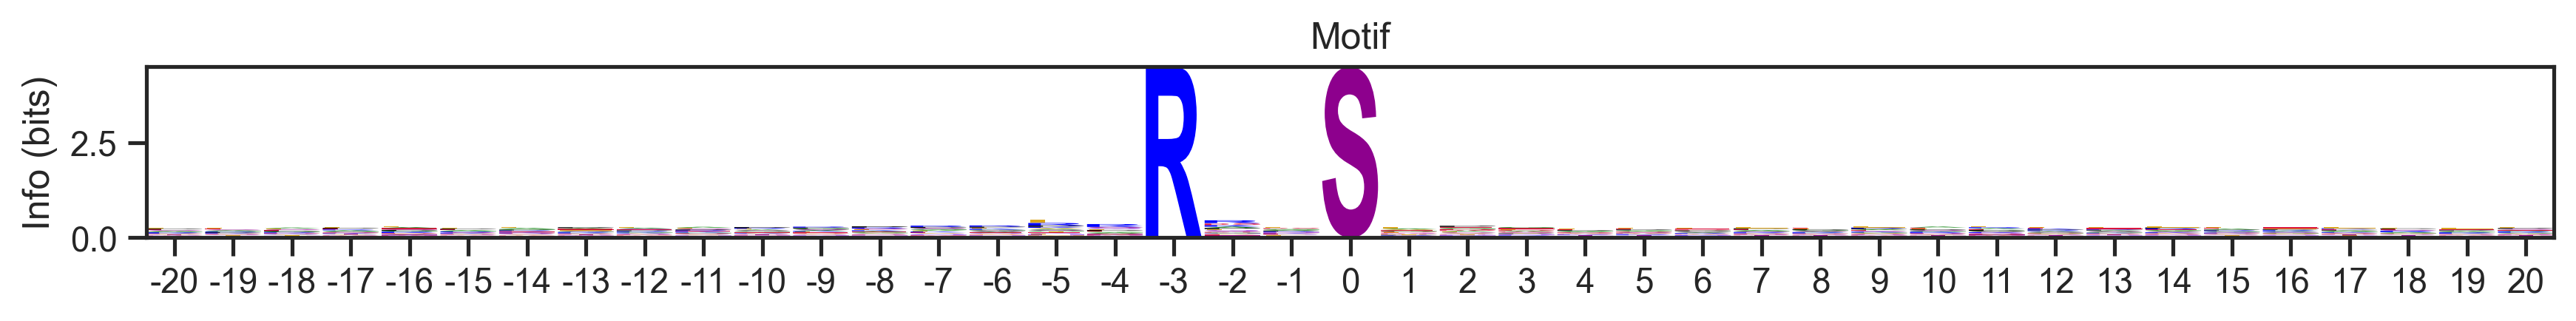

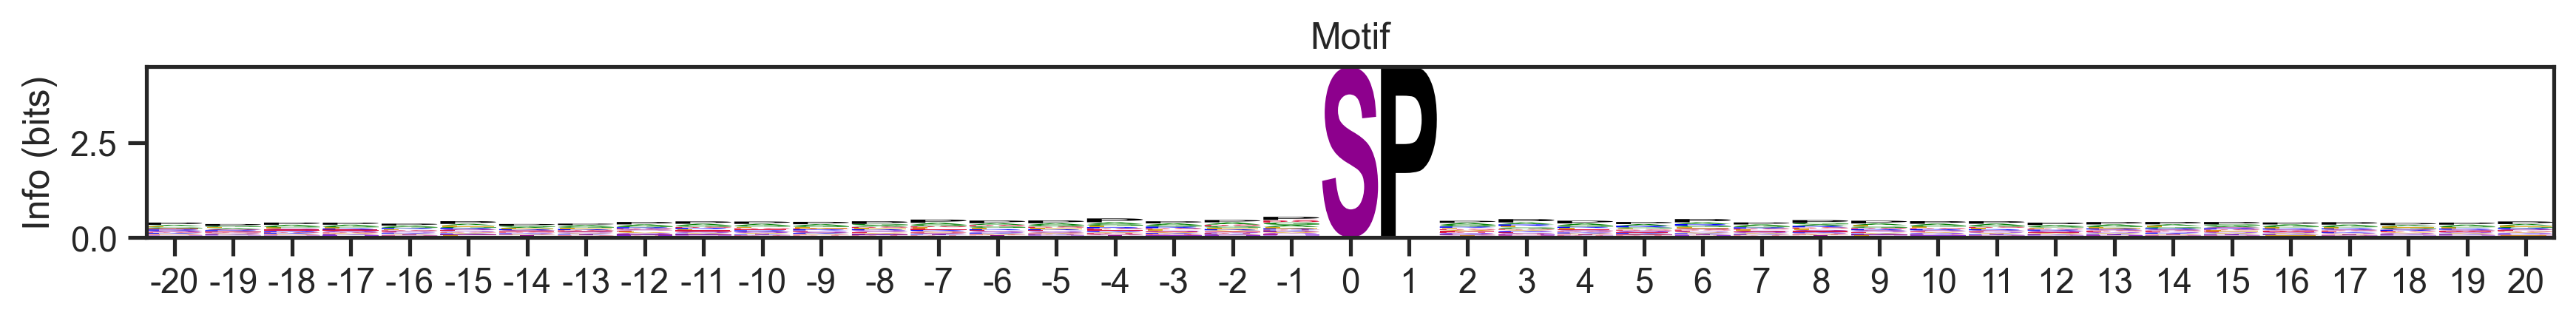

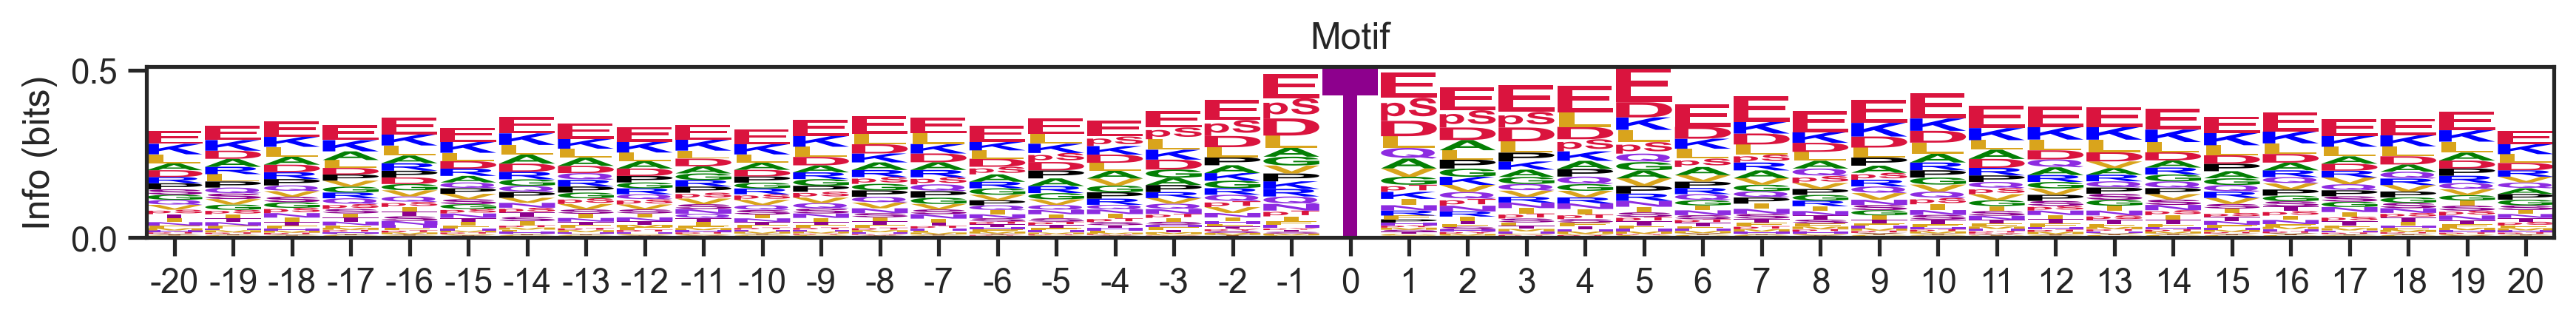

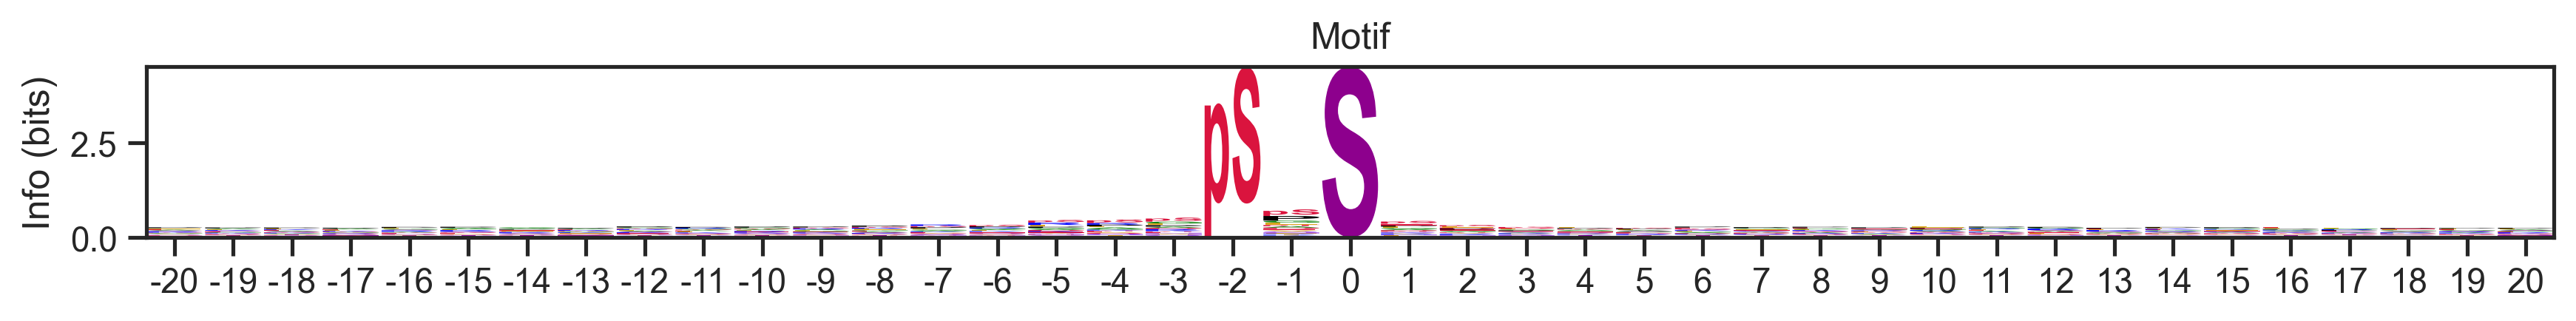

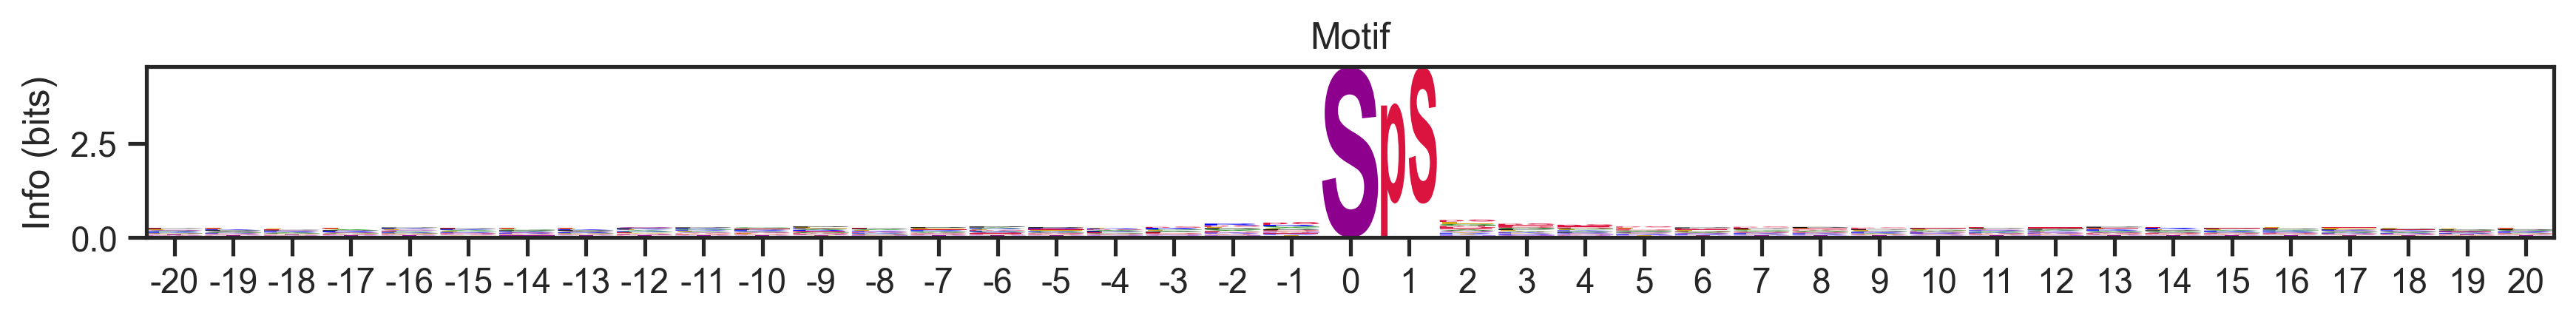

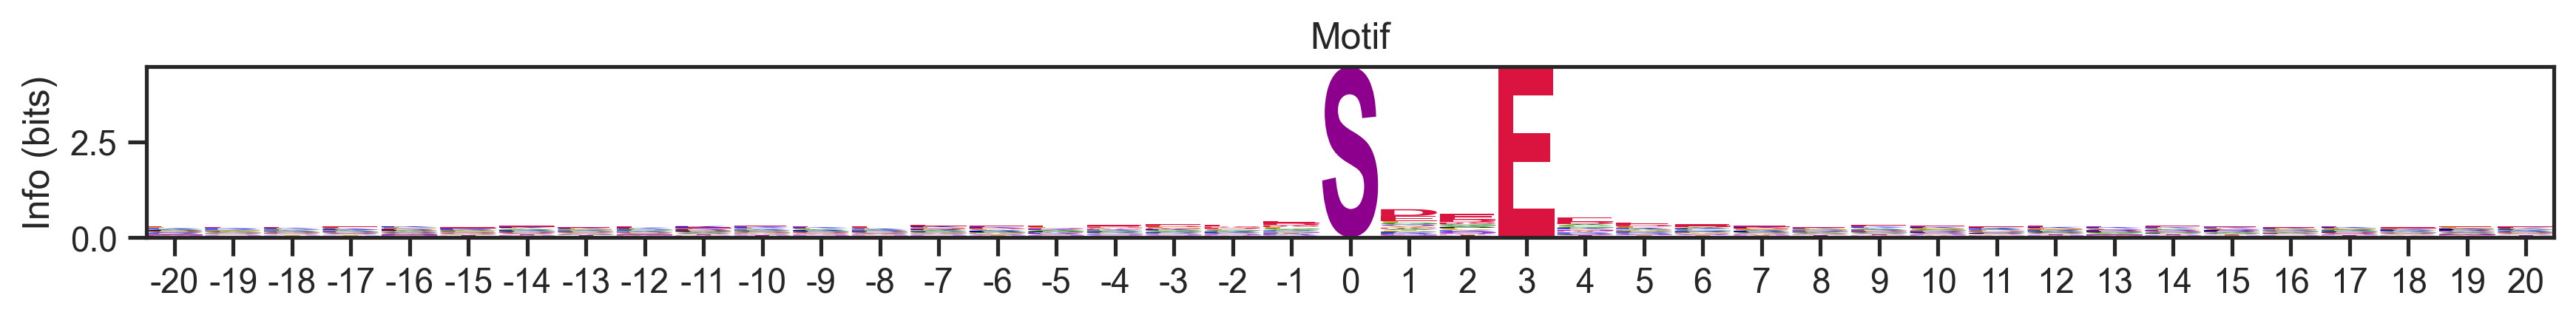

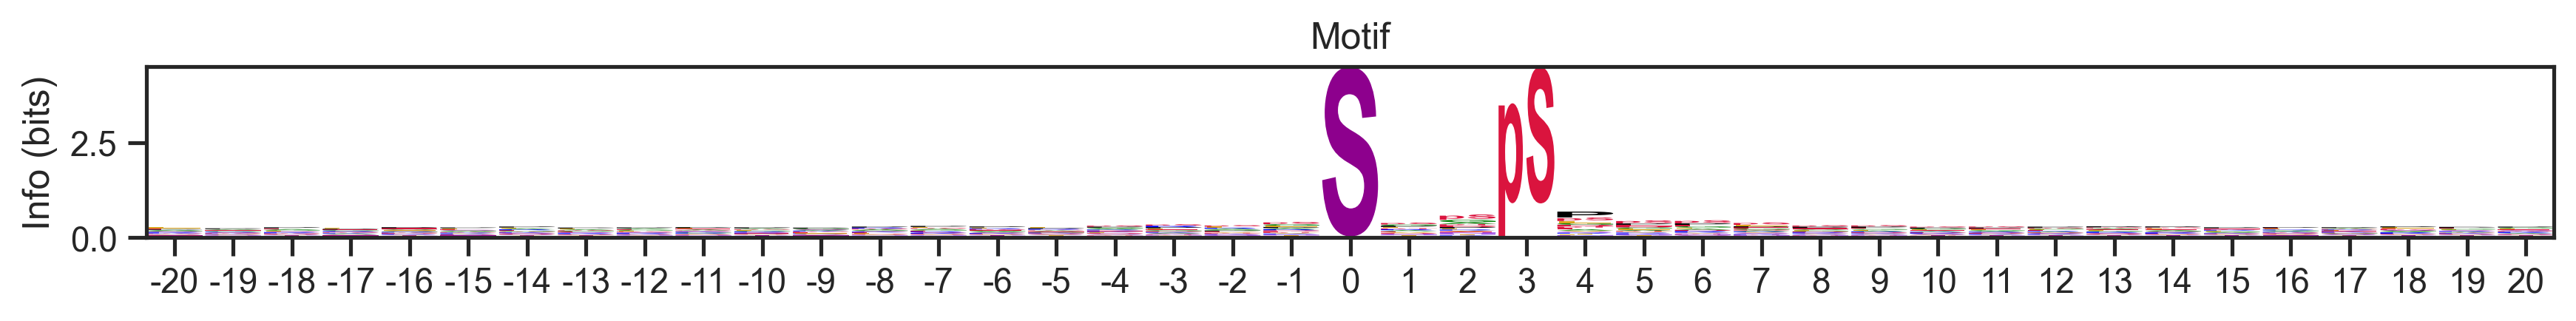

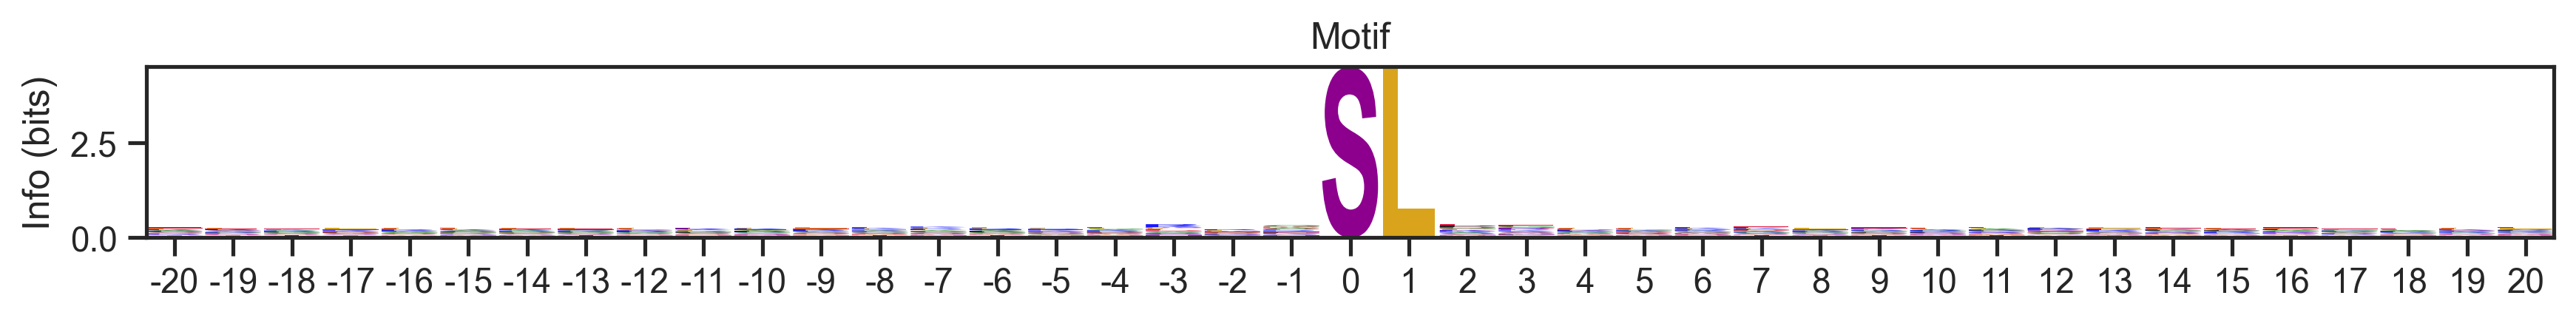

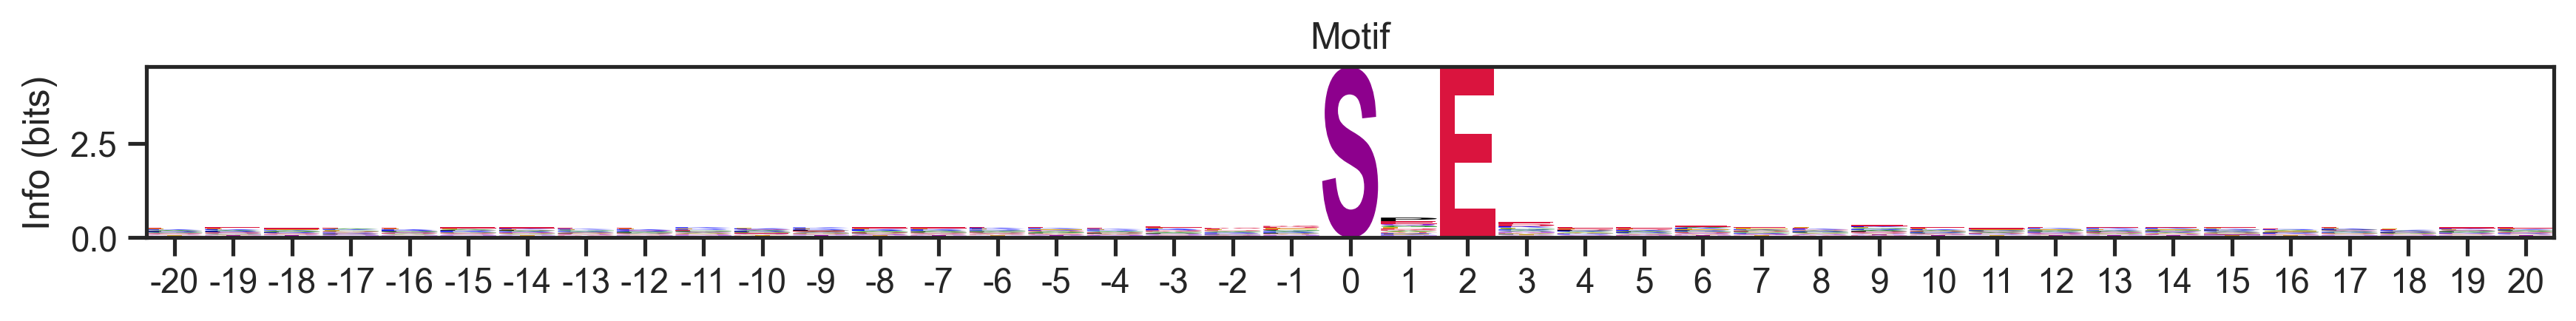

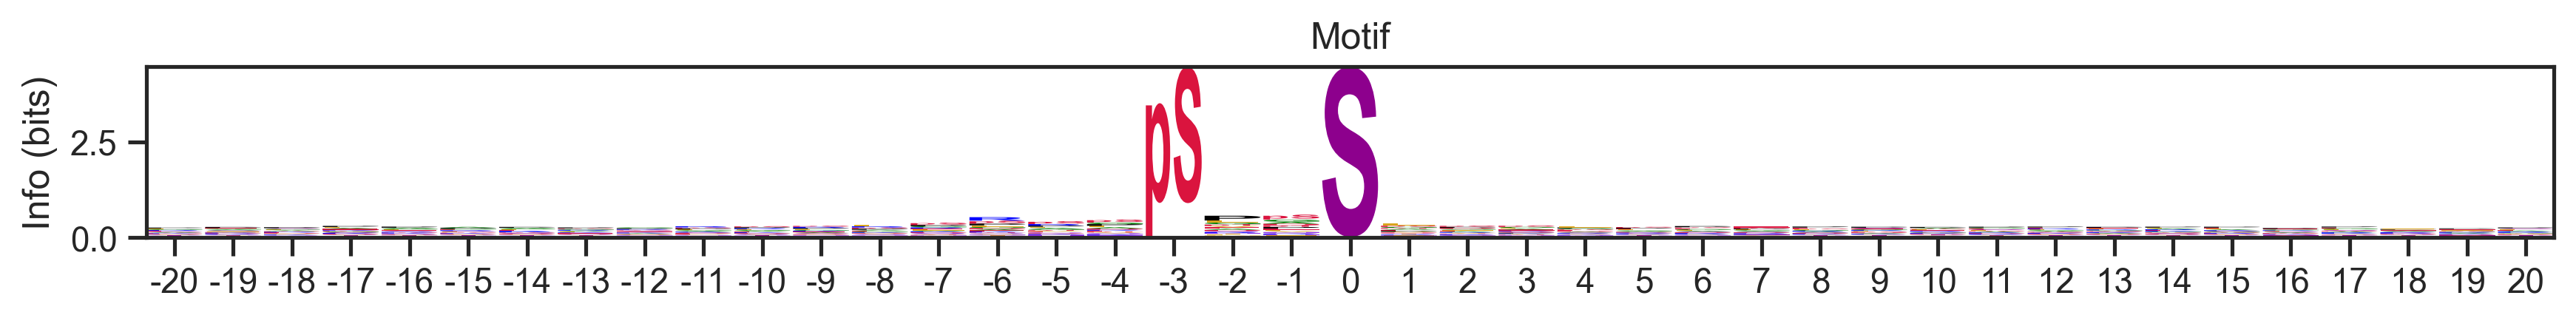

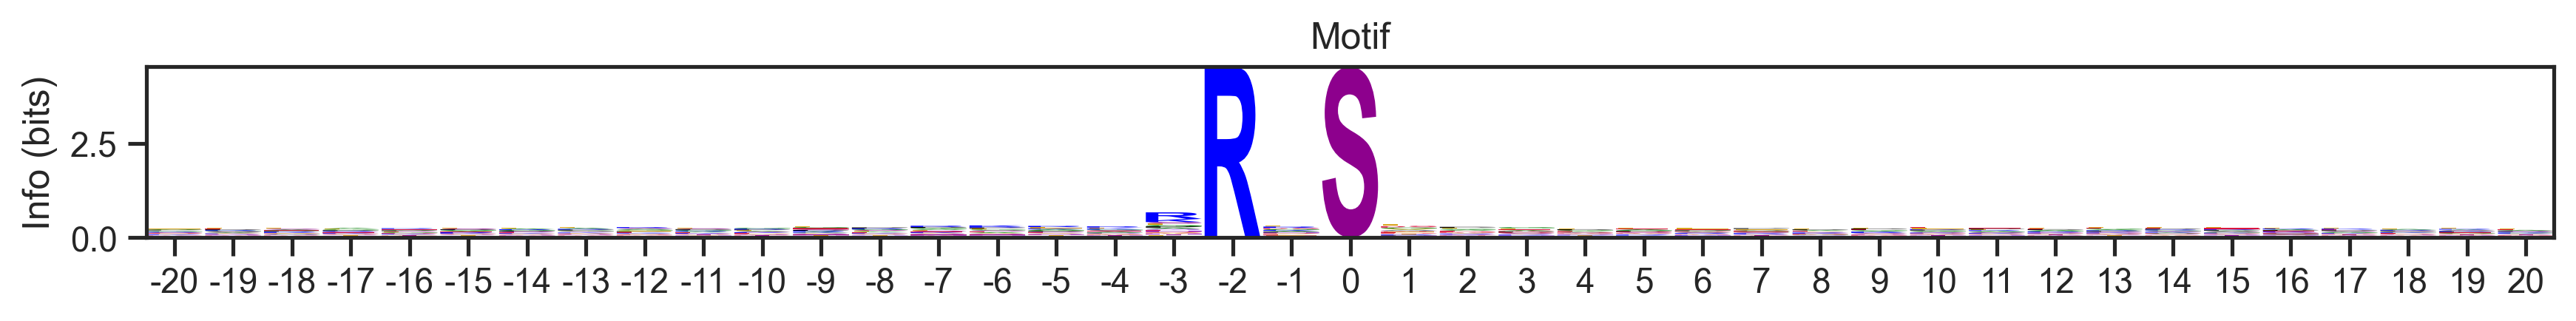

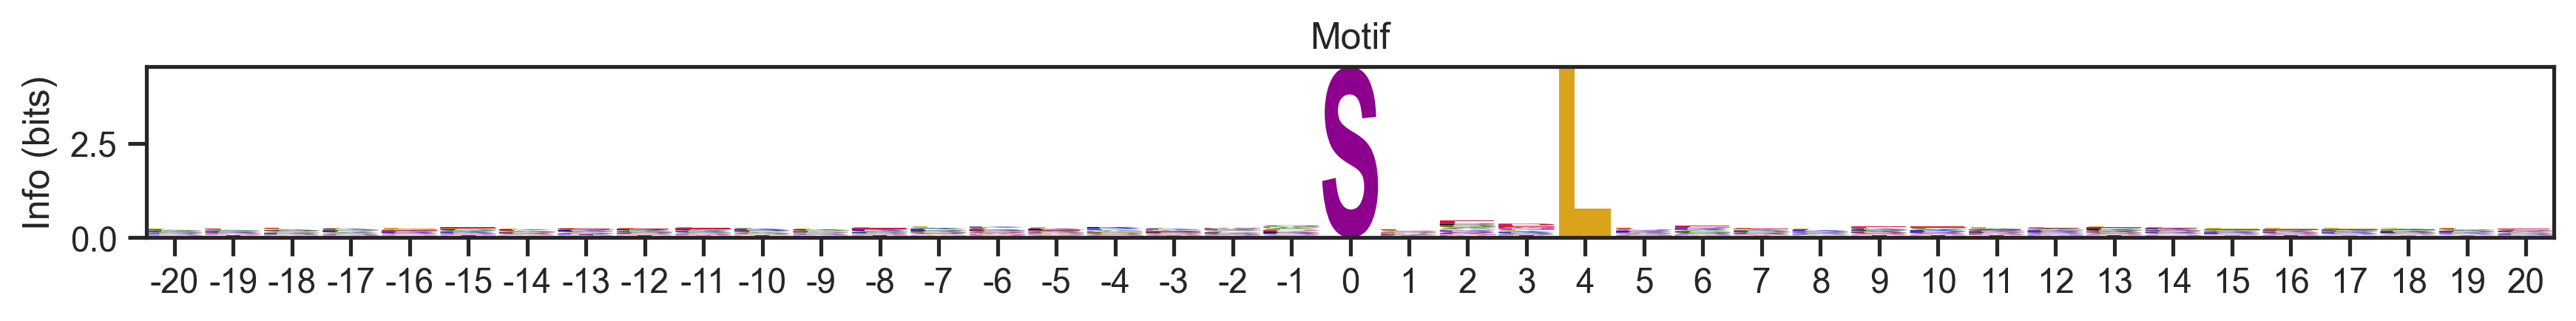

In [ ]:
plot_motifs(pssms2, *idxs)

In [ ]:
all_site_pivot

cluster_new     1    2    3    4    5    6    7    8    9    10   ...  737  \
sub_site                                                          ...        
A0A024R4G9_S20    0    0    0    0    0    0    0    0    0    0  ...    0   
A0A075B6Q4_S24    0    0    0    0    0    0    0    0    0    0  ...    0   
A0A075B6Q4_S35    0    0    0    0    0    0    0    0    0    0  ...    0   
A0A075B6Q4_S57    0    0    0    0    0    0    0    0    0    0  ...    0   
A0A075B6Q4_S68    0    0    0    0    0    0    0    0    0    0  ...    0   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
V9GYY5_S132       0    0    0    0    0    0    0    0    0    0  ...    0   
V9GYY5_S133       0    0    0    0    0    0    0    0    0    0  ...    0   
V9GYY5_T117       0    0    0    0    0    0    0    0    0    0  ...    0   
V9GYY5_T134       0    0    0    0    0    0    0    0    0    0  ...    0   
V9GYY5_T138       0    0    0    0    0    0    0    0    0    0  ...    0   

cluster_new     738  739  740  741  742  743  744  745  746  
sub_site                                                     
A0A024R4G9_S20    0    0    0    0    0    0    0    0    0  
A0A075B6Q4_S24    0    0    0    0    0    0    0    0    0  
A0A075B6Q4_S35    0    0    0    0    0    0    0    0    0  
A0A075B6Q4_S57    0    0    0    0    0    0    0    0    0  
A0A075B6Q4_S68    0    0    0    0    0    0    0    0    0  
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  
V9GYY5_S132       0    0    0    0    0    0    0    0    0  
V9GYY5_S133       0    0    0    0    0    0    0    0    0  
V9GYY5_T117       0    0    0    0    0    0    0    0    0  
V9GYY5_T134       0    0    0    0    0    0    0    0    0  
V9GYY5_T138       0    0    0    0    0    0    0    0    0  

[131843 rows x 746 columns]

## Umap

In [ ]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
annot = pd.DataFrame(all_site_pivot.index)

In [ ]:
annot = annot.merge(all_site[['sub_site','site','site_seq','substrate_genes']])

In [ ]:
sty = pd.get_dummies(annot['site'].str[0]).astype(int)

In [ ]:
sty = sty.set_index(all_site_pivot.index)

In [ ]:
all_site_pivot_sty = pd.concat([all_site_pivot,sty],axis=1)

In [ ]:
all_site_pivot_sty.head()

1  2  3  4  5  6  7  8  9  10  ...  740  741  742  743  744  \
sub_site                                       ...                            
A0A024R4G9_S20  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S24  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S35  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S57  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
A0A075B6Q4_S68  0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   

                745  746  S  T  Y  
sub_site                           
A0A024R4G9_S20    0    0  1  0  0  
A0A075B6Q4_S24    0    0  1  0  0  
A0A075B6Q4_S35    0    0  1  0  0  
A0A075B6Q4_S57    0    0  1  0  0  
A0A075B6Q4_S68    0    0  1  0  0  

[5 rows x 749 columns]

In [ ]:
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='jaccard',
    # min_dist=0.1,
    # random_state=42,
    # verbose=True,
)
embedding = reducer.fit_transform(all_site_pivot_sty)

f:\git\katlas\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
f:\git\katlas\.venv\lib\site-packages\logomaker/..\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [ ]:
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

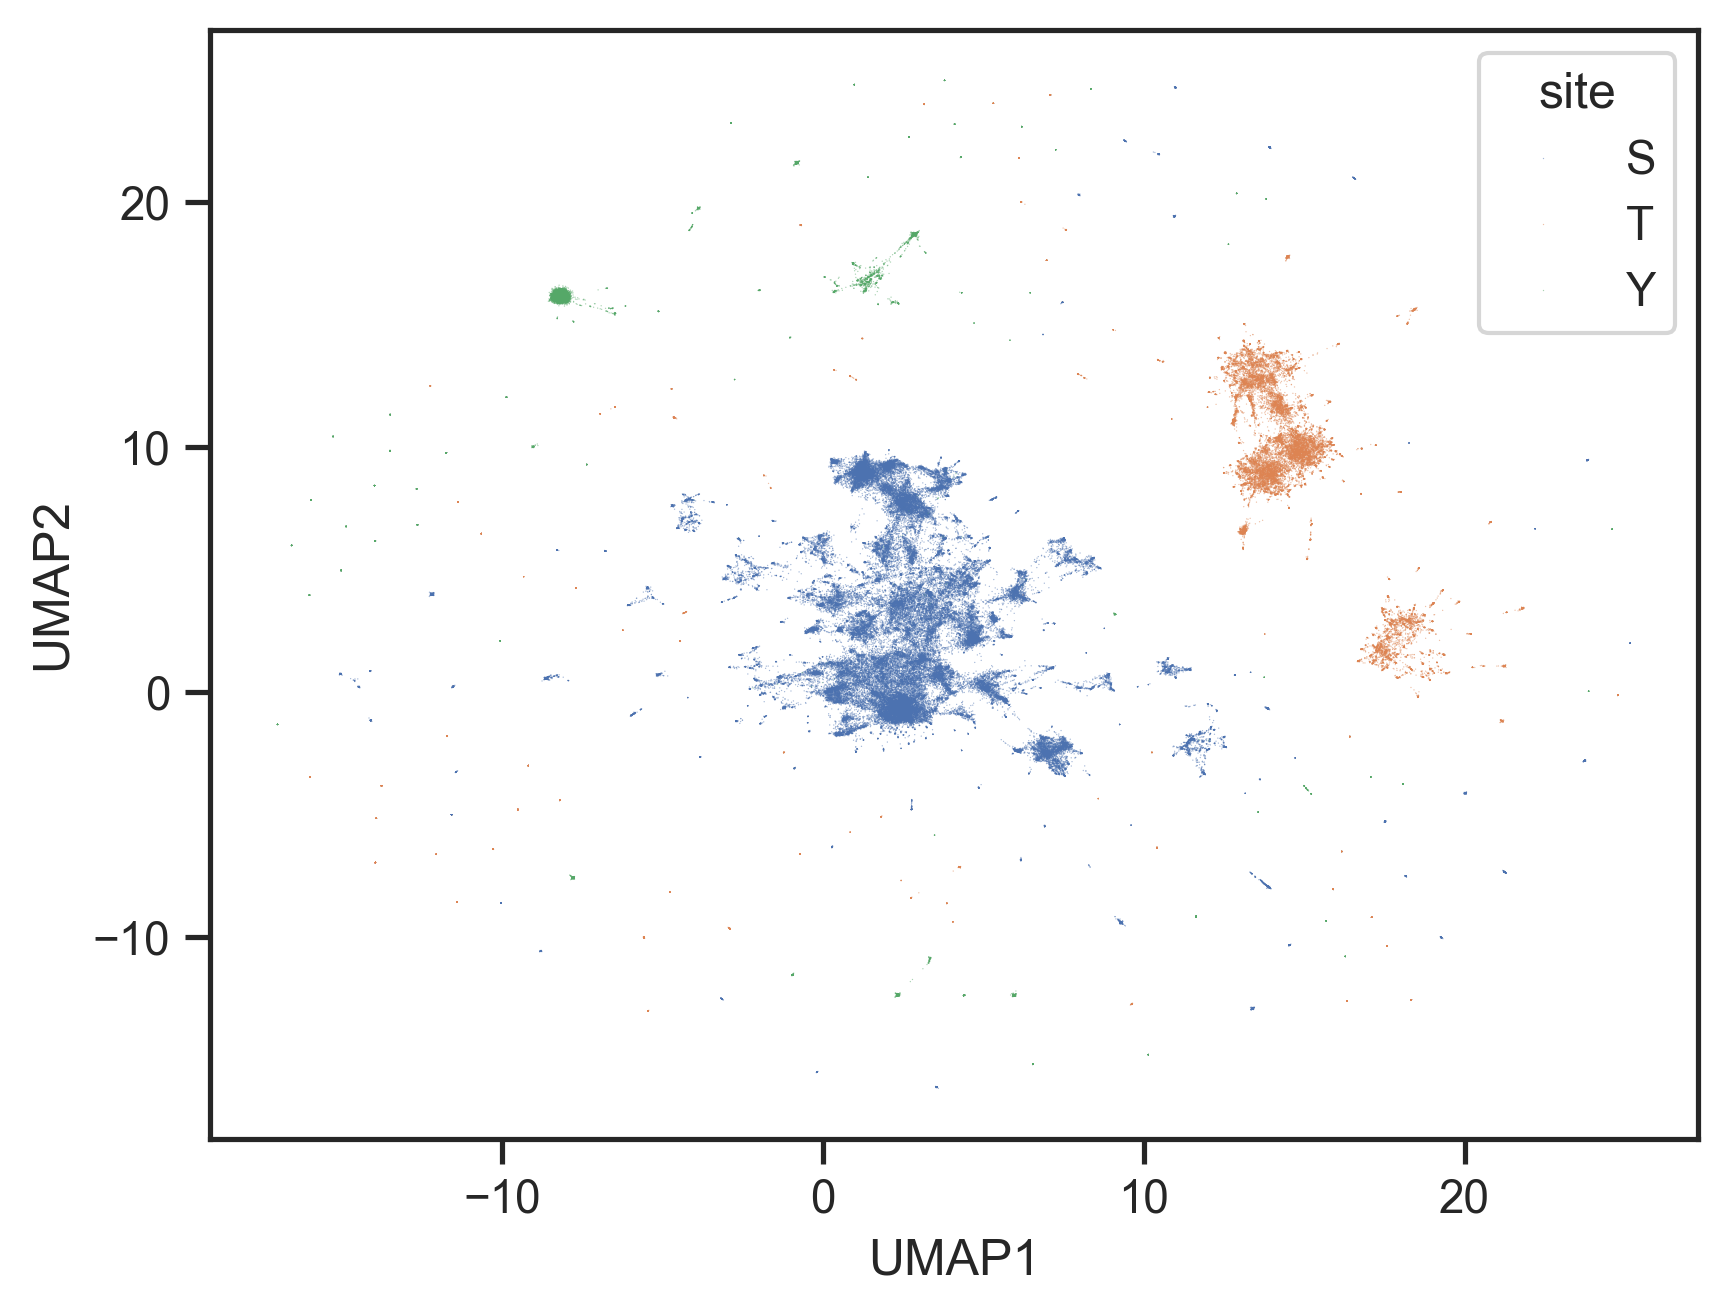

In [ ]:
sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', alpha=0.5,
                s=0.1,
                edgecolor='none',hue=annot['site'].str[0])

In [ ]:
annot['site_seq'].str.len()//2

0         20
1         20
2         20
3         20
4         20
          ..
131838    20
131839    20
131840    20
131841    20
131842    20
Name: site_seq, Length: 131843, dtype: int64

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

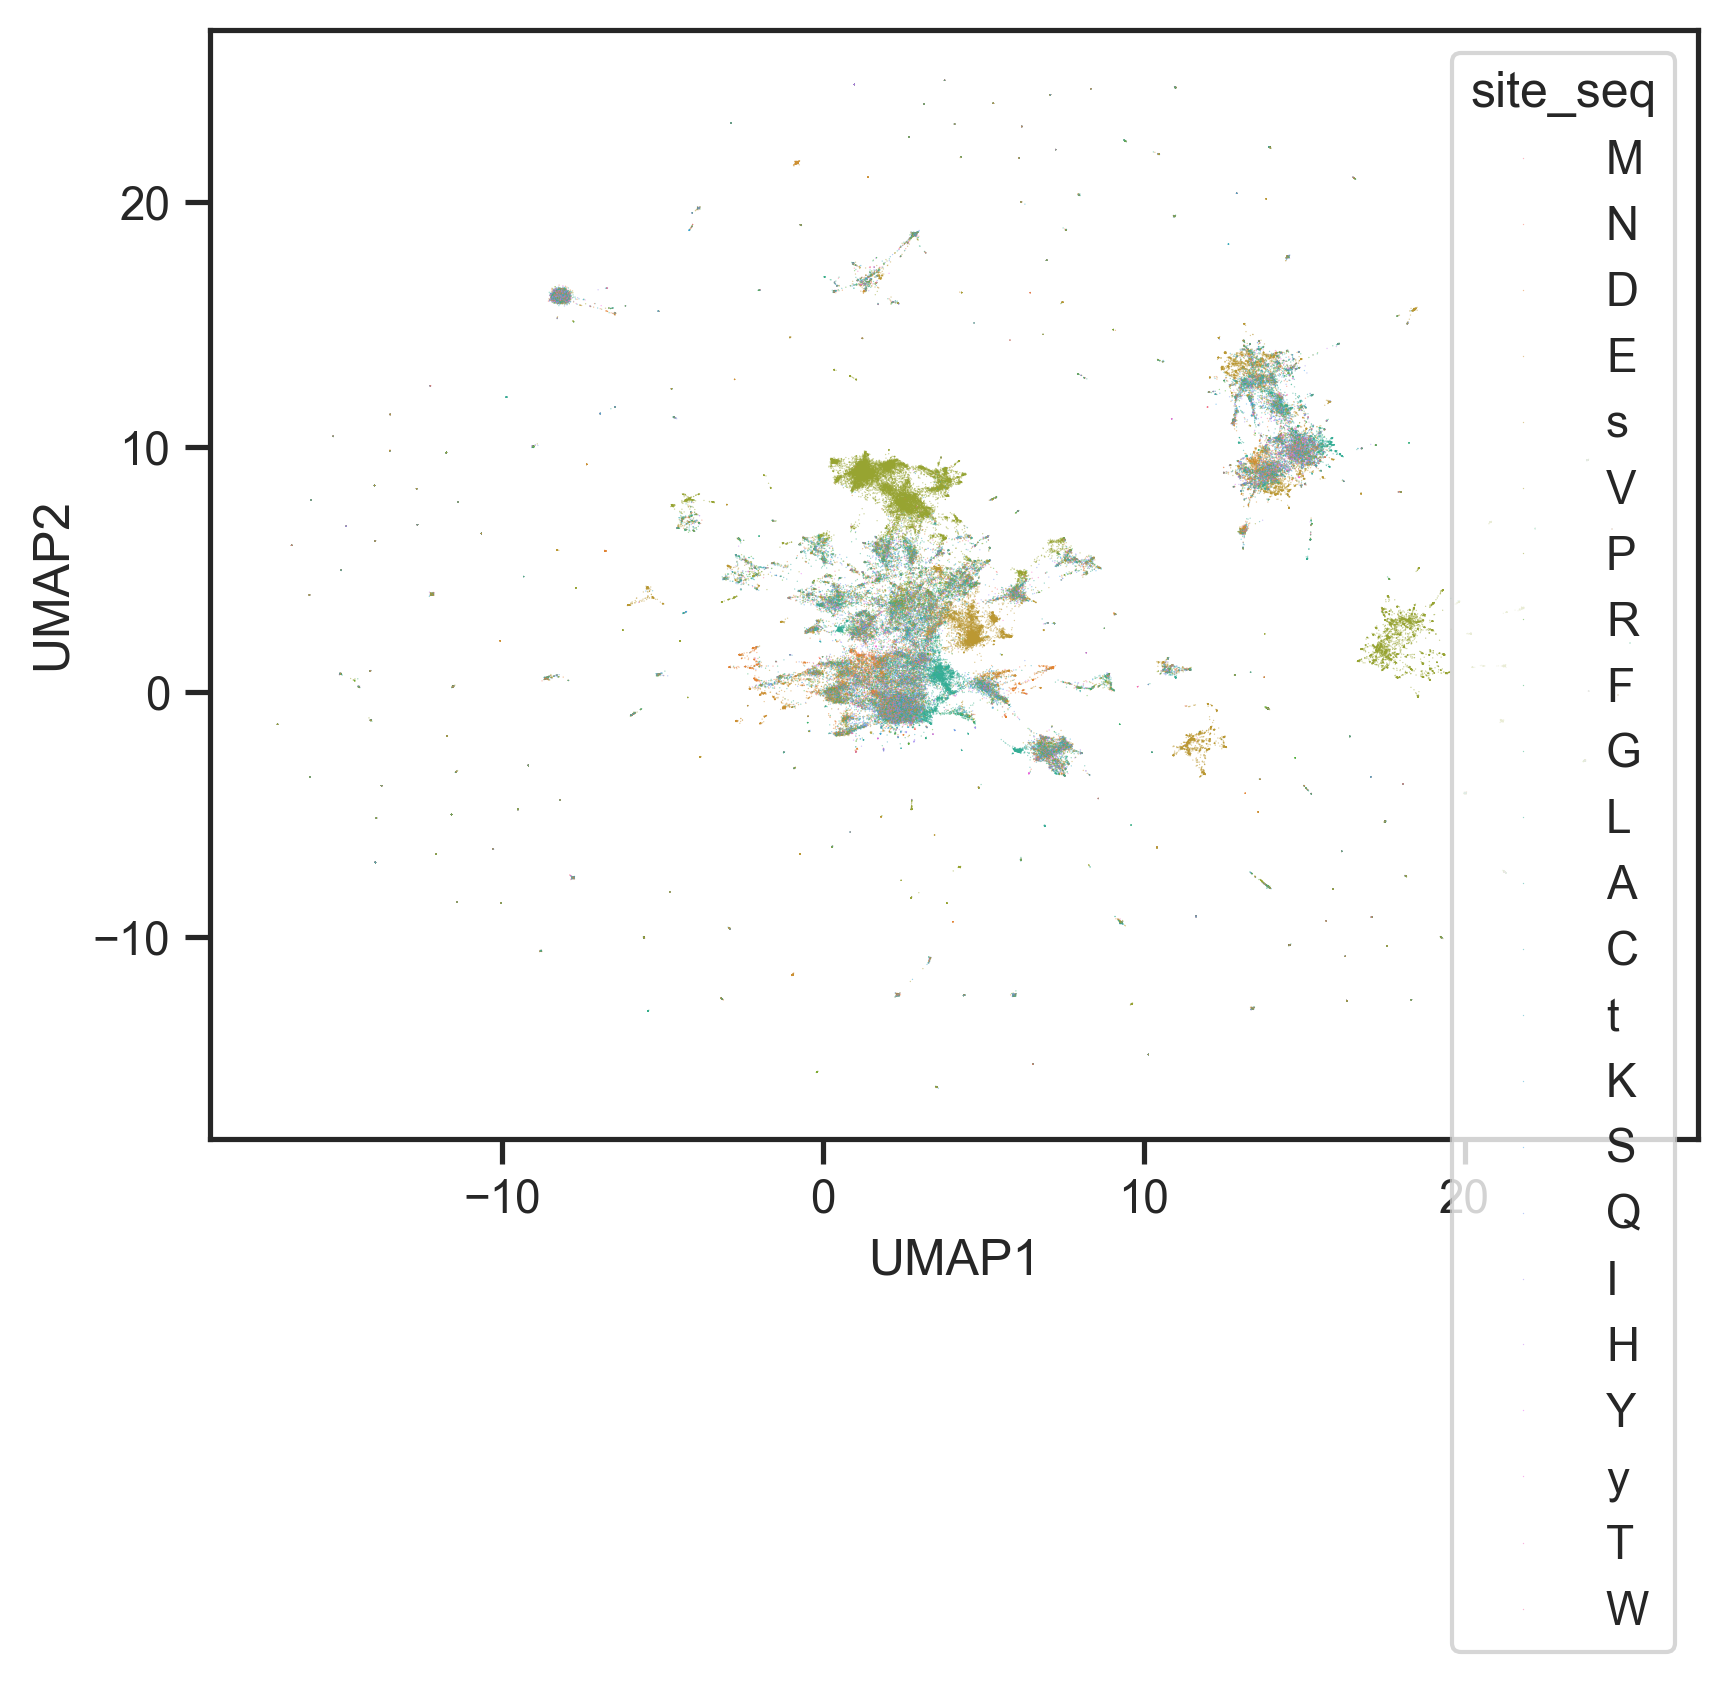

In [ ]:
sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', alpha=0.5,
                s=0.1,
                edgecolor='none',hue=annot['site_seq'].str[21])

## Entropy

In [ ]:
from katlas.core import *

In [ ]:
pspa = Data.get_pspa_all_norm()

In [ ]:
pspa.index.duplicated(keep=False).sum()

np.int64(0)

In [ ]:
pspa = pspa.dropna(axis=1) 

In [ ]:
entropy??

Signature: entropy(pssm_df, return_min=False, exclude_zero=False, contain_sty=True)
Source:   
def entropy(pssm_df,# a dataframe of pssm wtih index as aa and column as position
            return_min=False, # return min entropy as a single value or return all entropy as a series
            exclude_zero=False, # exclude the column of 0 (center position) in the entropy calculation
            contain_sty=True, # keep only s,t,y values (last three) in center 0 position
            ): 
    "Calculate entropy per position (max) of a PSSM surrounding 0"
    pssm_df = pssm_df.copy()
    pssm_df.columns= pssm_df.columns.astype(int)
    if 0 in pssm_df.columns:
        if exclude_zero:
            pssm_df = pssm_df.drop(columns=[0])
        if contain_sty:                       
            pssm_df.loc[pssm_df.index[:-3], 0] = 0
    pssm_df = pssm_df/pssm_df.sum()
    per_position = -np.sum(pssm_df * np.log2(pssm_df + 1e-9), axis=0)
    return per_position.min() if return_min else per_position

In [ ]:
entropy_flat??

Signature:
entropy_flat(
    flat_pssm: pandas.core.series.Series,
    return_min=False,
    exclude_zero=False,
    contain_sty=True,
)
Source:   
def entropy_flat(flat_pssm:pd.Series,return_min=False,exclude_zero=False,contain_sty=True): 
    "Calculate entropy per position of a flat PSSM surrounding 0"
    pssm_df = recover_pssm(flat_pssm)
    return entropy(pssm_df,return_min=return_min,exclude_zero=exclude_zero,contain_sty=contain_sty)
File:      f:\git\katlas\katlas\core.py
Type:      function

In [ ]:
entropies = []
ICs = []
for i,r in pspa.iterrows():
    entropies.append(entropy_flat(r,return_min=False).to_dict())
    ICs.append(get_IC_flat(r).to_dict())

In [ ]:
entropy_df = pd.DataFrame(entropies,index=pspa.index)
IC_df = pd.DataFrame(ICs,index=pspa.index)

In [ ]:
entropy_df

-5        -4        -3        -2        -1             0  \
kinase                                                                     
AAK1      4.238872  4.477492  4.419067  4.334337  4.285531  4.430518e-01   
ACVR2A    4.492276  4.483099  4.422408  3.851257  4.450203  9.999489e-01   
ACVR2B    4.480671  4.478871  4.409857  3.939154  4.426689  9.996887e-01   
AKT1      4.427160  4.402988  3.143867  3.590452  4.374148  9.659053e-01   
AKT2      4.427318  4.415247  2.970578  3.821267  4.416441  9.566125e-01   
...            ...       ...       ...       ...       ...           ...   
KDR       4.491261  4.472633  4.457427  4.448105  4.381677 -1.442695e-09   
FLT4      4.511274  4.501896  4.500559  4.504176  4.297943 -1.442695e-09   
WEE1_TYR  4.507984  4.495537  4.489914  4.470009  4.089527 -1.442695e-09   
YES1      4.497127  4.491665  4.442265  4.465032  4.274232 -1.442695e-09   
ZAP70     4.355980  4.260120  4.111361  4.128756  3.473012 -1.442695e-09   

                 1         2         3         4  
kinase                                            
AAK1      2.367128  4.484580  4.459749  4.448665  
ACVR2A    4.101970  4.509378  4.502156  4.509964  
ACVR2B    4.074009  4.491815  4.508044  4.505800  
AKT1      4.334536  4.429082  4.442455  4.412808  
AKT2      4.467609  4.463490  4.452789  4.435681  
...            ...       ...       ...       ...  
KDR       4.390681  4.443358  4.152800  4.462793  
FLT4      4.290937  4.344806  4.154417  4.498858  
WEE1_TYR  4.284853  4.403815  4.301392  4.426540  
YES1      4.350331  4.485518  4.275385  4.492019  
ZAP70     3.634941  4.358286  4.286572  4.474739  

[396 rows x 10 columns]

In [ ]:
# columns surrounding 0
cols = pspa.columns[~pspa.columns.str.startswith('0')]

In [ ]:
pspa[cols].max(1).sort_values()

kinase
VRK2         0.0941
ROS1         0.0983
TYK2         0.0995
LIMK1_TYR    0.1027
RET          0.1027
              ...  
YANK2        3.7589
GSK3B        3.9147
YANK3        4.2045
CK1A         5.8890
CK1G3        8.4920
Length: 396, dtype: float64

In [ ]:
def plot_dots(df,ylabel='bits',figsize=(5,3)):
    df.columns = df.columns.astype(str)
    plt.figure(figsize=figsize)
    for i, col in enumerate(df.columns):
        x_jitter = np.random.normal(loc=i, scale=0.1, size=len(df))
        plt.scatter(x_jitter, df[col], alpha=0.7, s=5,edgecolors='none')

    plt.xticks(range(len(df.columns)), df.columns)
    plt.xlabel("Position")
    plt.ylabel(ylabel)

In [ ]:
def plot_violin(df, ylabel='bits', figsize=(5, 3)):
    df_melted = df.melt(var_name='Position', value_name='Value')
    plt.figure(figsize=figsize)

    sns.violinplot(x='Position', y='Value', data=df_melted, inner=None, density_norm='width')
    sns.stripplot(x='Position', y='Value', data=df_melted, color='k', size=2, jitter=True, alpha=0.5)

    plt.xlabel('Position')
    plt.ylabel(ylabel)
    plt.tight_layout()

In [ ]:
plot_violin(entropy_df,ylabel='Entropy (bits)')
plt.title('Entropy per Position');

plot_violin(IC_df,ylabel='Information content (bits)')
plt.title('Information Content per Position');

In [ ]:
plot_dots(IC_df,ylabel='Information Content (bits)')
plt.title('Information Content per Position');

plot_dots(entropy_df,ylabel='Entropy (bits)')
plt.title('Entropy per Position');

In [ ]:
entropy_df.columns

Index(['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4'], dtype='object')

In [ ]:
entropy_df2 = entropy_df.drop(columns=['0']).copy()

In [ ]:
entropy_df2.min(1).sort_values().head(20)

kinase
CK1G3     1.674890
CK1A      1.825040
YANK3     1.943948
YANK2     2.017911
P38G      2.053687
P38D      2.060065
GSK3B     2.067587
GSK3A     2.108316
CDK17     2.123790
CK1G2     2.148218
CDK3      2.198466
SBK       2.216507
CK1A2     2.221651
ERK7      2.223145
CK1D      2.236495
CDK16     2.255882
AAK1      2.367128
FAM20C    2.400912
CDK18     2.435806
CDK4      2.452885
dtype: float64